# DMDc

In [1]:
# glycoSMC/koopman/data_loader.py

import os
import pandas as pd
import numpy as np

def load_data(data_dir='../data/', fill_nans=True):
    """
    Load and concatenate all CSV files from the specified directory.

    Parameters
    ----------
    data_dir : str, optional
        Path to the data directory (default is '../data/').
    fill_nans : bool, optional
        If True, forward‑fill and backward‑fill any remaining NaNs in
        BG, insulin, and meal columns. If False, raise an error when NaNs
        are encountered.

    Returns
    -------
    dict
        Dictionary containing numpy arrays:
        - BG: blood glucose values (mg/dL)
        - insulin: insulin delivered (U)
        - meal: carbohydrate intake (g)
        - t_minutes: time in minutes
        - patient: patient identifier (as strings)
    """
    # Resolve absolute path to avoid working directory issues
    base_path = os.path.abspath(data_dir)
    if not os.path.isdir(base_path):
        raise FileNotFoundError(f"Data directory not found: {base_path}")

    csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base_path}")

    df_list = []
    for file in csv_files:
        file_path = os.path.join(base_path, file)
        df = pd.read_csv(file_path, parse_dates=['time'])
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    # Sort by patient and time to ensure chronological order
    df_all.sort_values(['patient', 'time'], inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    # Check for missing values in essential columns
    essential_cols = ['BG', 'insulin', 'meal']
    if df_all[essential_cols].isnull().any().any():
        if fill_nans:
            print("Warning: Missing values detected. Applying forward‑fill then backward‑fill.")
            # Forward fill within each patient group to avoid mixing patients
            # Use ffill() and bfill() (method='ffill' is deprecated)
            df_all[essential_cols] = df_all.groupby('patient')[essential_cols].transform(
                lambda group: group.ffill().bfill()
            )
            # If still any NaNs (e.g., all NaN for a patient), raise error
            if df_all[essential_cols].isnull().any().any():
                raise ValueError("Unable to fill all NaNs. Please check the data.")
        else:
            raise ValueError("Input data contains NaNs. Set fill_nans=True or clean the data.")

    # Extract required columns as numpy arrays
    BG = df_all['BG'].values.astype(np.float64)
    insulin = df_all['insulin'].values.astype(np.float64)
    meal = df_all['meal'].values.astype(np.float64)
    t_minutes = df_all['t_minutes'].values.astype(np.float64)
    patient = df_all['patient'].values.astype(str)

    # Basic sanity check: sampling interval should be 3 minutes
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, 3):
        print(f"Warning: Sampling interval not uniformly 3 minutes. Found: {unique_diffs}")

    return {
        'BG': BG,
        'insulin': insulin,
        'meal': meal,
        't_minutes': t_minutes,
        'patient': patient
    }

In [2]:
# glycoSMC/koopman/embedding.py

import numpy as np

def build_embedding(BG, insulin, meal, g_delays=4, ins_delays=2, meal_delays=2):
    """
    Construct delay‑embedded lifted states for DMDc.

    The lifted state at time index k is:
        z_k = [g_k, g_{k-1}, g_{k-2}, g_{k-3},
               u_ins_k, u_ins_{k-1},
               u_meal_k, u_meal_{k-1}]^T   (size = g_delays + ins_delays + meal_delays)

    The control input at time k is:
        u_k = [insulin_k, meal_k]^T

    Parameters
    ----------
    BG : np.ndarray, shape (T,)
        Blood glucose time series.
    insulin : np.ndarray, shape (T,)
        Insulin delivery time series.
    meal : np.ndarray, shape (T,)
        Meal intake time series.
    g_delays : int, optional
        Number of glucose delays (including current) (default 4).
    ins_delays : int, optional
        Number of insulin delays to include in state (current and past) (default 2).
    meal_delays : int, optional
        Number of meal delays to include in state (current and past) (default 2).

    Returns
    -------
    Z : np.ndarray, shape (state_dim, N)
        Matrix of lifted states (columns are z_k for k = start_idx ... end_idx).
    Z_next : np.ndarray, shape (state_dim, N)
        Matrix of one‑step ahead lifted states (z_{k+1}).
    U : np.ndarray, shape (2, N)
        Matrix of control inputs (u_k).
    """
    # Check for NaNs or infinite values in input
    for arr, name in zip([BG, insulin, meal], ['BG', 'insulin', 'meal']):
        if not np.all(np.isfinite(arr)):
            raise ValueError(f"Input array '{name}' contains non‑finite values (NaN or inf).")

    T = len(BG)
    state_dim = g_delays + ins_delays + meal_delays  # should be 4+2+2 = 8

    # Indices required:
    # For z_k we need BG[k], BG[k-1], ..., BG[k-(g_delays-1)] → k >= g_delays-1
    # Also insulin[k], insulin[k-1], ..., insulin[k-(ins_delays-1)] → k >= ins_delays-1
    # Similarly meal delays → k >= meal_delays-1
    # The most restrictive is the maximum of these lower bounds.
    # Since we also need z_{k+1} (for Z_next), the highest k must be ≤ T-2.
    start_idx = max(g_delays - 1, ins_delays - 1, meal_delays - 1)  # = 3
    end_idx = T - 2  # inclusive, so that k+1 ≤ T-1
    if end_idx < start_idx:
        raise ValueError("Not enough data points for the requested delays.")

    N = end_idx - start_idx + 1
    Z = np.zeros((state_dim, N))
    Z_next = np.zeros((state_dim, N))
    U = np.zeros((2, N))

    for i, k in enumerate(range(start_idx, end_idx + 1)):
        # Current lifted state z_k
        Z[0, i] = BG[k]                     # g_k
        Z[1, i] = BG[k-1]                   # g_{k-1}
        Z[2, i] = BG[k-2]                   # g_{k-2}
        Z[3, i] = BG[k-3]                   # g_{k-3}
        Z[4, i] = insulin[k]                 # u_ins_k
        Z[5, i] = insulin[k-1]               # u_ins_{k-1}
        Z[6, i] = meal[k]                    # u_meal_k
        Z[7, i] = meal[k-1]                  # u_meal_{k-1}

        # Control input u_k
        U[0, i] = insulin[k]
        U[1, i] = meal[k]

        # Next lifted state z_{k+1}
        Z_next[0, i] = BG[k+1]               # g_{k+1}
        Z_next[1, i] = BG[k]                 # g_k
        Z_next[2, i] = BG[k-1]               # g_{k-1}
        Z_next[3, i] = BG[k-2]               # g_{k-2}
        Z_next[4, i] = insulin[k+1]           # u_ins_{k+1}
        Z_next[5, i] = insulin[k]             # u_ins_k
        Z_next[6, i] = meal[k+1]              # u_meal_{k+1}
        Z_next[7, i] = meal[k]                # u_meal_k

    return Z, Z_next, U

In [3]:
# glycoSMC/koopman/train_dmdc.py

import os
import numpy as np
import matplotlib.pyplot as plt



def main():
    # -------------------- Data Loading --------------------
    data_dir = os.path.join('..', 'data')
    print("Loading data...")
    data = load_data(data_dir, fill_nans=True)  # fill any NaNs automatically
    BG = data['BG']
    insulin = data['insulin']
    meal = data['meal']
    t_minutes = data['t_minutes']
    print(f"Total samples: {len(BG)}")

    # -------------------- Embedding --------------------
    print("\nBuilding delay embedding...")
    Z, Z_next, U = build_embedding(BG, insulin, meal)
    n_state, N = Z.shape
    print(f"Lifted state dimension: {n_state}")
    print(f"Number of snapshots: {N}")

    # Additional sanity: ensure no NaNs in constructed matrices
    for mat, name in zip([Z, Z_next, U], ['Z', 'Z_next', 'U']):
        if not np.all(np.isfinite(mat)):
            raise ValueError(f"Constructed matrix '{name}' contains NaNs or infs.")

    # -------------------- Train / Test Split --------------------
    # Use first 80% of snapshots for training, last 20% for testing
    split_idx = int(0.8 * N)
    Z_train = Z[:, :split_idx]
    Z_next_train = Z_next[:, :split_idx]
    U_train = U[:, :split_idx]

    Z_test = Z[:, split_idx:]
    Z_next_test = Z_next[:, split_idx:]
    U_test = U[:, split_idx:]

    print(f"\nTraining snapshots: {Z_train.shape[1]}")
    print(f"Testing snapshots : {Z_test.shape[1]}")

    # -------------------- DMDc Training (full rank) --------------------
    print("\nPerforming DMDc with full rank...")
    A_full, B_full, s = fit_dmdc(Z_train, Z_next_train, U_train, rank=None)

    # Plot singular values and suggest rank
    fig_sv = plot_singular_values(s)
    plt.savefig('singular_values.png', dpi=150)
    plt.show()

    # Compute cumulative energy
    energy = np.cumsum(s**2) / np.sum(s**2)
    print("\nCumulative energy explained:")
    for r in [3, 4, 5, 6]:
        print(f"  rank {r}: {energy[r-1]:.4f}")

    # Choose rank based on elbow (here we pick 4 as an example)
    chosen_rank = 4
    print(f"\nRetraining with rank = {chosen_rank}")
    A, B, _ = fit_dmdc(Z_train, Z_next_train, U_train, rank=chosen_rank)

    # -------------------- Eigenvalue Analysis --------------------
    fig_eig = plot_eigenvalues(A)
    plt.savefig('eigenvalues.png', dpi=150)
    plt.show()

    # Compute time constants (for eigenvalues inside unit circle)
    eigvals = np.linalg.eigvals(A)
    dt = 3.0  # minutes
    tau = -dt / np.log(np.abs(eigvals))
    print("\nEstimated time constants (minutes) for stable modes:")
    for i, (ev, tc) in enumerate(zip(eigvals, tau)):
        if np.abs(ev) < 1.0:
            print(f"  Mode {i+1}: |λ|={np.abs(ev):.4f}, τ={tc:.2f} min")

    # -------------------- Multi‑step Prediction on Test Set --------------------
    # We will predict a 2‑hour horizon (40 steps) starting from the first test snapshot
    prediction_steps = 40  # 40 * 3 min = 120 min
    if prediction_steps > Z_test.shape[1]:
        prediction_steps = Z_test.shape[1] - 1

    z0 = Z_test[:, 0]
    U_seq = U_test[:, :prediction_steps]

    # True glucose over the horizon (first component of state)
    true_glucose = Z_test[0, :prediction_steps+1]

    # Predict
    Z_pred = predict_multi_step(A, B, z0, U_seq)
    pred_glucose = Z_pred[0, :]  # first component

    # Time axis for the horizon
    start_time = t_minutes[split_idx]  # approximate
    time_axis = start_time + np.arange(prediction_steps+1) * dt

    # Compute RMSE
    rmse = compute_rmse(true_glucose, pred_glucose)
    print(f"\nPrediction RMSE over {prediction_steps} steps ({prediction_steps*dt:.0f} min): {rmse:.2f} mg/dL")

    # Plot predictions
    fig_pred = plot_predictions(time_axis, true_glucose, pred_glucose)
    plt.savefig('prediction.png', dpi=150)
    plt.show()

    print("\nTraining and evaluation complete.")

if __name__ == '__main__':
    main()

Loading data...
Total samples: 10083

Building delay embedding...
Lifted state dimension: 8
Number of snapshots: 10079

Training snapshots: 8063
Testing snapshots : 2016

Performing DMDc with full rank...


NameError: name 'fit_dmdc' is not defined

# eDMDc

In [21]:
# glycoSMC/koopman/lifting.py

import numpy as np

def lift_features(BG, insulin, meal):
    """
    Lift the observed variables into a higher‑dimensional feature space.

    The feature map φ(x_k) for a single time step is defined as:

        φ = [g, g^2, g^3, u_i, u_i^2, u_m, g*u_i, g*u_m]^T

    where:
        g   = BG (glucose)
        u_i = insulin delivery
        u_m = meal intake

    The function is vectorized to operate on entire time series.

    Parameters
    ----------
    BG : np.ndarray, shape (T,)
        Blood glucose time series.
    insulin : np.ndarray, shape (T,)
        Insulin delivery time series.
    meal : np.ndarray, shape (T,)
        Meal intake time series.

    Returns
    -------
    Phi : np.ndarray, shape (n_features, T)
        Matrix of lifted feature vectors (columns correspond to time steps).
        n_features = 8 as defined above.
    """
    # Ensure inputs are 1D numpy arrays
    BG = np.asarray(BG).ravel()
    insulin = np.asarray(insulin).ravel()
    meal = np.asarray(meal).ravel()

    T = len(BG)
    # Preallocate feature matrix
    n_features = 8
    Phi = np.zeros((n_features, T))

    # Fill features row by row
    Phi[0, :] = BG                     # g
    Phi[1, :] = BG ** 2                 # g^2
    Phi[2, :] = BG ** 3                 # g^3
    Phi[3, :] = insulin                 # u_i
    Phi[4, :] = insulin ** 2             # u_i^2
    Phi[5, :] = meal                    # u_m
    Phi[6, :] = BG * insulin             # g * u_i
    Phi[7, :] = BG * meal                # g * u_m

    # Check for NaNs or Infs
    if not np.all(np.isfinite(Phi)):
        raise ValueError("Lifted feature matrix contains non‑finite values (NaN or inf).")

    return Phi

In [22]:
# glycoSMC/koopman/edmdc_model.py

import numpy as np
from scipy.linalg import svd

def fit_edmdc(Phi, Phi_next, U, rank=None):
    """
    Learn the extended DMD with control (eDMDc) matrices A and B.

    The model is: φ_{k+1} = A φ_k + B u_k.

    Parameters
    ----------
    Phi : np.ndarray, shape (n_features, N)
        Matrix of lifted states at current time (columns φ_k).
    Phi_next : np.ndarray, shape (n_features, N)
        Matrix of lifted states at next time (φ_{k+1}).
    U : np.ndarray, shape (m, N)
        Matrix of control inputs (u_k).
    rank : int or None, optional
        Truncation rank for the pseudoinverse. If None, use all singular values.

    Returns
    -------
    A : np.ndarray, shape (n_features, n_features)
        State transition matrix in the lifted space.
    B : np.ndarray, shape (n_features, m)
        Input matrix.
    s : np.ndarray, shape (min(n_features+m, N),)
        Singular values of the stacked data matrix [Phi; U].
    """
    n = Phi.shape[0]          # lifted state dimension
    m = U.shape[0]            # input dimension
    N = Phi.shape[1]          # number of snapshots

    # Build stacked data matrix Omega = [Phi; U]
    Omega = np.vstack([Phi, U])          # shape (n+m, N)

    # Full SVD
    U1, s, Vh = svd(Omega, full_matrices=False)

    if rank is None:
        rank = len(s)
    else:
        if rank > len(s):
            raise ValueError(f"Requested rank {rank} exceeds number of singular values {len(s)}")
        rank = int(rank)

    # Truncated pseudoinverse of Omega
    # Omega_pinv = Vh^T * Sigma^{-1} * U1^T  (only first r components)
    Omega_pinv = Vh[:rank, :].T @ np.diag(1.0 / s[:rank]) @ U1[:, :rank].T

    # Solve for [A B]
    AB = Phi_next @ Omega_pinv            # shape (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]

    return A, B, s

In [23]:
# glycoSMC/koopman/evaluate_edmdc.py

import numpy as np
import matplotlib.pyplot as plt

def predict_multi_step_edmdc(A, B, phi0, U_seq):
    """
    Perform multi‑step prediction using the learned eDMDc model.

    Parameters
    ----------
    A : np.ndarray, shape (n, n)
        State transition matrix in lifted space.
    B : np.ndarray, shape (n, m)
        Input matrix.
    phi0 : np.ndarray, shape (n,)
        Initial lifted state.
    U_seq : np.ndarray, shape (m, steps)
        Sequence of control inputs for each future step.

    Returns
    -------
    Phi_pred : np.ndarray, shape (n, steps+1)
        Predicted lifted states including the initial state.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    return Phi_pred

def compute_rmse(true, pred):
    """
    Root mean square error between true and predicted signals.

    Parameters
    ----------
    true : np.ndarray
        Ground truth values.
    pred : np.ndarray
        Predicted values.

    Returns
    -------
    float
        RMSE.
    """
    return np.sqrt(np.mean((true - pred) ** 2))

def plot_singular_values_edmdc(s, rank_choice=None):
    """
    Plot the singular value spectrum of the stacked data matrix.

    Parameters
    ----------
    s : np.ndarray
        Singular values.
    rank_choice : int or None, optional
        If provided, mark the chosen rank with a vertical line.
    """
    plt.figure(figsize=(8, 5))
    plt.semilogy(s, 'o-', markersize=4, label='Singular values')
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of $[\\Phi; U]$ (eDMDc)')
    plt.grid(alpha=0.3)
    if rank_choice is not None:
        plt.axvline(x=rank_choice-1, color='r', linestyle='--', label=f'Chosen rank = {rank_choice}')
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

def plot_eigenvalues_edmdc(A):
    """
    Plot eigenvalues of A in the complex plane with the unit circle.

    Parameters
    ----------
    A : np.ndarray, shape (n, n)
        State transition matrix.
    """
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6, 6))
    plt.plot(np.real(eigvals), np.imag(eigvals), 'bo', markersize=8, label='Eigenvalues')
    # Draw unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit circle')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Eigenvalues of A (eDMDc)')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

def plot_predictions_edmdc(time_axis, true_glucose, pred_glucose):
    """
    Overlay true and predicted glucose time series.

    Parameters
    ----------
    time_axis : np.ndarray, shape (steps+1,)
        Time points for the prediction horizon.
    true_glucose : np.ndarray, shape (steps+1,)
        True glucose values (first component of lifted state).
    pred_glucose : np.ndarray, shape (steps+1,)
        Predicted glucose values.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, true_glucose, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred_glucose, 'r--', linewidth=1.5, label='Predicted BG (eDMDc)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Multi‑step glucose prediction with eDMDc')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

Loading data...
Total samples: 10083

Applying nonlinear feature lifting...
Lifted state dimension: 8
Number of time steps: 10083

Training snapshots: 8065
Testing snapshots : 2017

--- Training with full ---
Number of stable modes: 6
Estimated time constants (minutes) for stable modes:
  Mode 3: |λ|=0.1905, τ=1.81 min
  Mode 4: |λ|=0.1905, τ=1.81 min
  Mode 5: |λ|=0.0258, τ=0.82 min

--- Training with rank=3 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9999, τ=25776.83 min
  Mode 2: |λ|=0.9950, τ=594.75 min
  Mode 3: |λ|=0.0000, τ=0.07 min

--- Training with rank=4 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9999, τ=25776.27 min
  Mode 2: |λ|=0.9950, τ=594.76 min
  Mode 3: |λ|=0.0745, τ=1.16 min

--- Training with rank=5 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9917, τ=361.83 min
  Mode 2: |λ|=0.9982, τ=1664.98 min
  Mod

C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:31: RuntimeWarning: overflow encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:31: RuntimeWarning: invalid value encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:50: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((true - pred) ** 2))


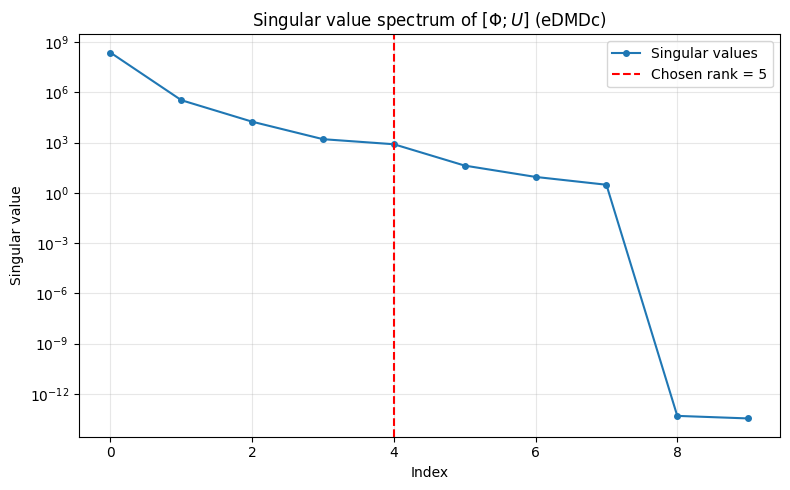

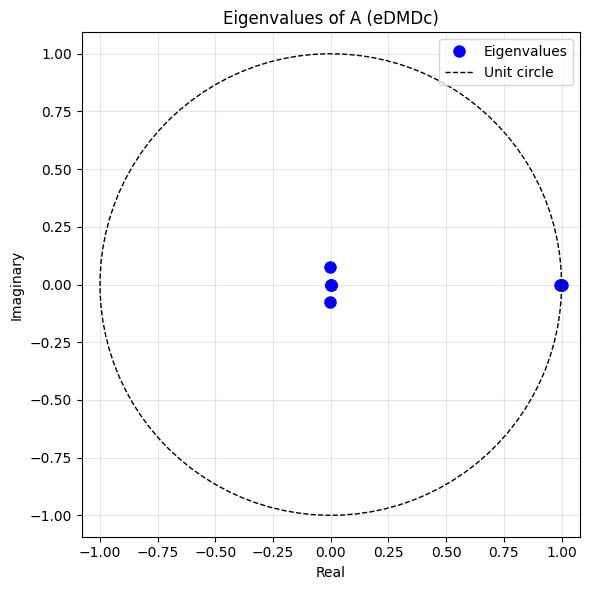

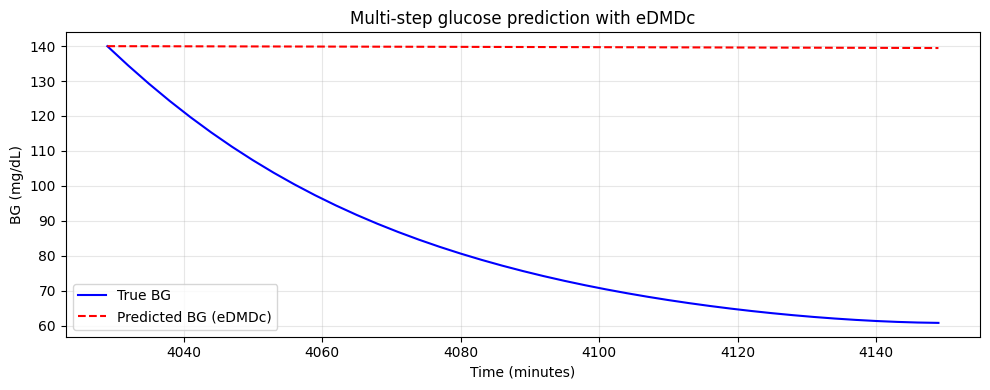


Training and evaluation complete.


In [24]:
# glycoSMC/koopman/train_edmdc.py

import os
import numpy as np
import matplotlib.pyplot as plt



def main():
    # -------------------- Data Loading --------------------
    data_dir = os.path.join('..', 'data')
    print("Loading data...")
    data = load_data(data_dir, fill_nans=True)
    BG = data['BG']
    insulin = data['insulin']
    meal = data['meal']
    t_minutes = data['t_minutes']
    print(f"Total samples: {len(BG)}")

    # -------------------- Lifting --------------------
    print("\nApplying nonlinear feature lifting...")
    Phi = lift_features(BG, insulin, meal)   # shape (n_features, T)
    n_features, T = Phi.shape
    print(f"Lifted state dimension: {n_features}")
    print(f"Number of time steps: {T}")

    # Construct Phi_next (shifted by one) and U (control input)
    # We need aligned pairs: (Phi_k, u_k) → Phi_{k+1}
    # Use all but the last sample for Phi, and all but the first for Phi_next.
    # U corresponds to u_k.
    Phi_k = Phi[:, :-1]                # shape (n_features, T-1)
    Phi_kp1 = Phi[:, 1:]               # shape (n_features, T-1)
    U = np.vstack([insulin[:-1], meal[:-1]])   # shape (2, T-1)

    # -------------------- Train / Test Split --------------------
    # Use first 80% of snapshots for training, last 20% for testing
    N = Phi_k.shape[1]
    split_idx = int(0.8 * N)
    Phi_train = Phi_k[:, :split_idx]
    Phi_next_train = Phi_kp1[:, :split_idx]
    U_train = U[:, :split_idx]

    Phi_test = Phi_k[:, split_idx:]
    Phi_next_test = Phi_kp1[:, split_idx:]
    U_test = U[:, split_idx:]

    print(f"\nTraining snapshots: {Phi_train.shape[1]}")
    print(f"Testing snapshots : {Phi_test.shape[1]}")

    # -------------------- Train with different ranks --------------------
    ranks_to_try = [None, 3, 4, 5]   # None means full rank
    results = {}

    for rank in ranks_to_try:
        rank_str = "full" if rank is None else f"rank={rank}"
        print(f"\n--- Training with {rank_str} ---")
        A, B, s = fit_edmdc(Phi_train, Phi_next_train, U_train, rank=rank)

        # Store results for later comparison
        results[rank_str] = {'A': A, 'B': B, 's': s}

        # Compute eigenvalues and time constants
        eigvals = np.linalg.eigvals(A)
        dt = 3.0  # minutes
        tau = -dt / np.log(np.abs(eigvals))
        stable_modes = [i for i, ev in enumerate(eigvals) if np.abs(ev) < 1.0]
        print(f"Number of stable modes: {len(stable_modes)}")
        if stable_modes:
            print("Estimated time constants (minutes) for stable modes:")
            for i in stable_modes[:3]:   # show first few
                print(f"  Mode {i+1}: |λ|={np.abs(eigvals[i]):.4f}, τ={tau[i]:.2f} min")

    # -------------------- Choose best rank based on test RMSE --------------------
    # We'll evaluate 2‑hour prediction (40 steps) on test set for each rank
    prediction_steps = 40
    if prediction_steps > Phi_test.shape[1]:
        prediction_steps = Phi_test.shape[1] - 1

    # True glucose over the horizon (first component of lifted state)
    # We need the initial lifted state and the corresponding true BG sequence.
    # We'll use the first test snapshot as initial condition.
    phi0 = Phi_test[:, 0]
    U_seq = U_test[:, :prediction_steps]
    true_glucose = Phi_test[0, :prediction_steps+1]   # first feature is BG

    print("\n--- Evaluating on test set (2‑hour prediction) ---")
    best_rmse = np.inf
    best_rank_str = None
    best_A = None
    best_B = None

    for rank_str, model in results.items():
        A = model['A']
        B = model['B']
        Phi_pred = predict_multi_step_edmdc(A, B, phi0, U_seq)
        pred_glucose = Phi_pred[0, :]   # first feature is BG
        rmse = compute_rmse(true_glucose, pred_glucose)
        results[rank_str]['rmse'] = rmse
        print(f"{rank_str}: RMSE = {rmse:.2f} mg/dL")
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank_str = rank_str
            best_A = A
            best_B = B

    print(f"\nBest model: {best_rank_str} with RMSE = {best_rmse:.2f} mg/dL")

    # -------------------- Plot singular values for the best model --------------------
    # Use the singular values from the full rank training for illustration
    s_full = results['full']['s']
    rank_chosen = 4 if best_rank_str == 'rank=4' else (5 if best_rank_str == 'rank=5' else None)
    fig_sv = plot_singular_values_edmdc(s_full, rank_choice=rank_chosen)
    plt.savefig('edmdc_singular_values.png', dpi=150)
    plt.show()

    # -------------------- Plot eigenvalues for the best model --------------------
    fig_eig = plot_eigenvalues_edmdc(best_A)
    plt.savefig('edmdc_eigenvalues.png', dpi=150)
    plt.show()

    # -------------------- Plot prediction for the best model --------------------
    # Recompute prediction with best model
    Phi_pred_best = predict_multi_step_edmdc(best_A, best_B, phi0, U_seq)
    pred_glucose_best = Phi_pred_best[0, :]
    start_time = t_minutes[split_idx] if split_idx < len(t_minutes) else t_minutes[-1]
    time_axis = start_time + np.arange(prediction_steps+1) * 3.0
    fig_pred = plot_predictions_edmdc(time_axis, true_glucose, pred_glucose_best)
    plt.savefig('edmdc_prediction.png', dpi=150)
    plt.show()

    print("\nTraining and evaluation complete.")

if __name__ == '__main__':
    main()

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd

# ----------------------------------------------------------------------
# Data loading
# ----------------------------------------------------------------------
def load_data(data_dir):
    """Load and concatenate all CSV files from data_dir."""
    base_path = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base_path}")

    df_list = []
    for f in csv_files:
        df_list.append(pd.read_csv(os.path.join(base_path, f), parse_dates=['time']))
    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Fill missing values (forward then backward) within each patient
    essential = ['BG', 'insulin', 'meal']
    if df[essential].isnull().any().any():
        df[essential] = df.groupby('patient')[essential].transform(lambda g: g.ffill().bfill())
        if df[essential].isnull().any().any():
            raise ValueError("Unable to fill all NaNs. Check the data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)
    return BG, insulin, meal, t_minutes

# ----------------------------------------------------------------------
# Normalization
# ----------------------------------------------------------------------
def normalize_train_test(train, test):
    """Standardize to zero mean, unit variance using training statistics."""
    mean = np.mean(train, axis=0, keepdims=True)
    std = np.std(train, axis=0, keepdims=True)
    std[std == 0] = 1.0   # avoid division by zero
    train_norm = (train - mean) / std
    test_norm = (test - mean) / std
    return train_norm, test_norm, mean.ravel(), std.ravel()

# ----------------------------------------------------------------------
# Feature lifting (no cubic terms)
# ----------------------------------------------------------------------
def lift_features(BG, insulin, meal):
    """
    Construct lifted feature matrix Φ from normalized variables.
    Features: [g, g², u_i, u_m, g*u_i, g*u_m]
    Returns array of shape (6, T).
    """
    BG = BG.ravel()
    insulin = insulin.ravel()
    meal = meal.ravel()
    T = len(BG)
    Phi = np.zeros((6, T))
    Phi[0, :] = BG
    Phi[1, :] = BG ** 2
    Phi[2, :] = insulin
    Phi[3, :] = meal
    Phi[4, :] = BG * insulin
    Phi[5, :] = BG * meal
    return Phi

# ----------------------------------------------------------------------
# Build eDMDc data matrices
# ----------------------------------------------------------------------
def build_matrices(Phi, U):
    """
    From lifted features Φ (6 x T) and control inputs U (2 x T),
    construct X = Φ_k, X' = Φ_{k+1}, Umat = u_k for k = 0..T-2.
    Returns X, Xprime, Umat each as 2D arrays (features x snapshots).
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]               # Φ_k
    Xprime = Phi[:, 1:]            # Φ_{k+1}
    Umat = U[:, :-1]               # u_k
    return X, Xprime, Umat

# ----------------------------------------------------------------------
# Ridge regression solution for eDMDc
# ----------------------------------------------------------------------
def fit_edmdc_ridge(X, Xprime, U, lambda_reg=1e-4):
    """
    Solve [A B] = X' Ωᵀ (Ω Ωᵀ + λI)^{-1} with Ω = [X; U].
    Returns A (6x6), B (6x2).
    """
    n = X.shape[0]          # feature dimension
    m = U.shape[0]          # input dimension
    Omega = np.vstack([X, U])   # (n+m) x N
    # Compute M = X' Ωᵀ
    M = Xprime @ Omega.T        # n x (n+m)
    # Gram matrix G = Ω Ωᵀ + λI
    G = Omega @ Omega.T + lambda_reg * np.eye(n + m)
    # Solve G * Y = Mᵀ  => Y = (A B)ᵀ
    Y = np.linalg.solve(G, M.T)   # (n+m) x n
    AB = Y.T                      # n x (n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
# Truncated SVD solution for eDMDc
# ----------------------------------------------------------------------
def fit_edmdc_truncated(X, Xprime, U, rank):
    """
    Use truncated SVD of Ω = [X; U] to compute [A B] = X' Ω^†.
    rank can be an integer or 'full' (all singular values).
    Returns A (6x6), B (6x2).
    """
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
# Multi-step prediction
# ----------------------------------------------------------------------
def predict_multi_step(A, B, phi0, U_seq, scaler):
    """
    Roll out the model for len(U_seq) steps.
    phi0: initial lifted state (6,)
    U_seq: input sequence (2, steps)
    scaler: tuple (mean_g, std_g) for denormalizing glucose (first feature)
    Returns predicted glucose (mg/dL) over steps+1 points.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # Denormalize glucose (first feature)
    mean_g, std_g = scaler
    glucose_pred = Phi_pred[0, :] * std_g + mean_g
    return glucose_pred

def compute_rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# ----------------------------------------------------------------------
# Plotting functions
# ----------------------------------------------------------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-')
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of Ω')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(eigvals), np.imag(eigvals), 'bo', markersize=6)
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of A')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', label='True BG')
    plt.plot(time_axis, pred, 'r--', label='Predicted BG (eDMDc)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Multi‑step glucose prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# ----------------------------------------------------------------------
# Main pipeline
# ----------------------------------------------------------------------
def main():
    # -------------------- 1. Load data --------------------
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_data(data_dir)
    T_total = len(BG)
    print(f"Total samples: {T_total}")

    # -------------------- 2. Train/test split (80/20) --------------------
    split_idx = int(0.8 * T_total)
    BG_train, BG_test = BG[:split_idx], BG[split_idx:]
    ins_train, ins_test = insulin[:split_idx], insulin[split_idx:]
    meal_train, meal_test = meal[:split_idx], meal[split_idx:]
    t_train, t_test = t_minutes[:split_idx], t_minutes[split_idx:]

    # -------------------- 3. Normalize using training statistics --------------------
    # Stack variables to normalize together (each variable separately)
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    test_stack = np.column_stack([BG_test, ins_test, meal_test])
    train_norm, test_norm, means, stds = normalize_train_test(train_stack, test_stack)
    BG_train_n, ins_train_n, meal_train_n = train_norm[:,0], train_norm[:,1], train_norm[:,2]
    BG_test_n, ins_test_n, meal_test_n = test_norm[:,0], test_norm[:,1], test_norm[:,2]

    # -------------------- 4. Feature lifting --------------------
    Phi_train = lift_features(BG_train_n, ins_train_n, meal_train_n)   # (6, T_train)
    Phi_test = lift_features(BG_test_n, ins_test_n, meal_test_n)       # (6, T_test)

    # Build control input matrices (normalized)
    U_train = np.vstack([ins_train_n, meal_train_n])   # (2, T_train)
    U_test = np.vstack([ins_test_n, meal_test_n])      # (2, T_test)

    # -------------------- 5. Build eDMDc data matrices (aligned pairs) --------------------
    X_train, Xprime_train, Umat_train = build_matrices(Phi_train, U_train)
    X_test, Xprime_test, Umat_test = build_matrices(Phi_test, U_test)

    # -------------------- 6. Prepare for rank sweep --------------------
    # Compute full SVD of Ω_train for later use in truncated solutions
    Omega_train = np.vstack([X_train, Umat_train])
    U_svd, s, Vh = svd(Omega_train, full_matrices=False)

    # Ridge solution (full rank, regularized)
    print("\n--- Training with ridge (λ=1e-4) ---")
    A_ridge, B_ridge = fit_edmdc_ridge(X_train, Xprime_train, Umat_train, lambda_reg=1e-4)

    # Candidate ranks: full ridge, and truncated SVD with ranks 2..6
    ranks = ['ridge', 2, 3, 4, 5, 6]
    results = {}

    # Evaluate ridge model
    # Need initial state for test prediction: use first test lifted state
    phi0_test = X_test[:, 0]   # corresponds to Φ at test index 0
    U_seq_test = Umat_test      # inputs for steps 0..N-2
    # We will predict up to 40 steps (or less if test set is shorter)
    max_steps = min(40, X_test.shape[1] - 1)   # because we need one extra for true next
    if max_steps < 1:
        raise ValueError("Test set too short for 2‑hour prediction.")

    true_glucose_denorm = BG_test[1:1+max_steps+1]  # align with predicted: start from second test sample? Wait careful.
    # The test lifted states X_test correspond to Φ_k for k in test set indices 0..L-2.
    # The first test state is at original time index split_idx+? Let's derive properly.
    # After lifting, the test lifted states X_test have columns corresponding to k from 0 to L-2.
    # The true glucose for these states is the first feature of X_test, but that's normalized.
    # To get denormalized glucose, we can use BG_test[1:] because X_test uses BG_test[1:] as the first feature? Actually:
    # X_test[:, i] = Φ at test time index i (which uses BG_test[i] as first feature). Then Xprime_test[:, i] uses BG_test[i+1].
    # So for prediction starting from phi0 = X_test[:,0], we need to predict BG_test[1], BG_test[2], ... .
    # The true glucose sequence for steps 0..max_steps (inclusive of initial) should be BG_test[0] (initial) and then predicted steps.
    # But we only care about prediction after step 0. We'll compute RMSE on steps 1..max_steps+1 (the predicted ones).
    # Let's define:
    true_glucose_denorm = BG_test[1:1+max_steps+1]   # length max_steps+1? Actually we predict max_steps steps, so we get max_steps+1 predicted points including initial.
    # If we predict max_steps steps, we have predicted glucose at times 0..max_steps. The true glucose at those times is BG_test[0:max_steps+1].
    # So we should align indices carefully.
    # Simpler: we will use the first max_steps+1 true glucose values from test set (starting at test index 0) for comparison.
    true_glucose_denorm = BG_test[:max_steps+1]   # length max_steps+1
    # Then we predict with U_seq_test[:, :max_steps] (inputs for steps 0..max_steps-1)
    U_seq_test_trunc = Umat_test[:, :max_steps]
    scaler = (means[0], stds[0])   # for glucose

    # Ridge prediction
    pred_ridge = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test_trunc, scaler)
    rmse_ridge = compute_rmse(true_glucose_denorm, pred_ridge)
    results['ridge'] = {'A': A_ridge, 'B': B_ridge, 'rmse': rmse_ridge}
    print(f"Ridge (full): RMSE = {rmse_ridge:.2f} mg/dL")

    # Evaluate truncated models
    for r in ranks[1:]:
        print(f"\n--- Training with rank {r} (truncated SVD) ---")
        A_trunc, B_trunc = fit_edmdc_truncated(X_train, Xprime_train, Umat_train, rank=r)
        pred_trunc = predict_multi_step(A_trunc, B_trunc, phi0_test, U_seq_test_trunc, scaler)
        rmse_trunc = compute_rmse(true_glucose_denorm, pred_trunc)
        results[r] = {'A': A_trunc, 'B': B_trunc, 'rmse': rmse_trunc}
        print(f"Rank {r}: RMSE = {rmse_trunc:.2f} mg/dL")

    # -------------------- 7. Select best rank --------------------
    best_rank = min(results, key=lambda k: results[k]['rmse'])
    best_rmse = results[best_rank]['rmse']
    best_A = results[best_rank]['A']
    best_B = results[best_rank]['B']
    print(f"\n*** Best model: {best_rank} with RMSE = {best_rmse:.2f} mg/dL ***")

    # -------------------- 8. Eigenanalysis of best model --------------------
    eigvals = np.linalg.eigvals(best_A)
    dt = 3.0   # minutes
    tau = -dt / np.log(np.abs(eigvals))
    print("\nTime constants for stable modes (|λ|<1):")
    for i, (ev, tc) in enumerate(zip(eigvals, tau)):
        if np.abs(ev) < 1.0:
            print(f"  Mode {i+1}: |λ|={np.abs(ev):.4f}, τ={tc:.2f} min")

    # -------------------- 9. Generate plots --------------------
    # Singular value spectrum of Omega_train
    plot_singular_values(s, 'edmdc_singular_values.png')
    # Eigenvalues of best A
    plot_eigenvalues(best_A, 'edmdc_eigenvalues.png')
    # Prediction plot
    time_axis = t_test[0] + np.arange(max_steps+1) * dt
    # Use best model prediction (already computed)
    if best_rank == 'ridge':
        pred_best = pred_ridge
    else:
        pred_best = predict_multi_step(best_A, best_B, phi0_test, U_seq_test_trunc, scaler)
    plot_predictions(time_axis, true_glucose_denorm, pred_best, 'edmdc_prediction.png')

    print("\nPlots saved: edmdc_singular_values.png, edmdc_eigenvalues.png, edmdc_prediction.png")
    print("Pipeline finished successfully.")

if __name__ == '__main__':
    main()

Total samples: 10083

--- Training with ridge (λ=1e-4) ---
Ridge (full): RMSE = 56.12 mg/dL

--- Training with rank 2 (truncated SVD) ---
Rank 2: RMSE = 45.62 mg/dL

--- Training with rank 3 (truncated SVD) ---
Rank 3: RMSE = 45.14 mg/dL

--- Training with rank 4 (truncated SVD) ---
Rank 4: RMSE = 55.99 mg/dL

--- Training with rank 5 (truncated SVD) ---
Rank 5: RMSE = 55.98 mg/dL

--- Training with rank 6 (truncated SVD) ---
Rank 6: RMSE = 56.12 mg/dL

*** Best model: 3 with RMSE = 45.14 mg/dL ***

Time constants for stable modes (|λ|<1):
  Mode 1: |λ|=0.9955, τ=664.09 min
  Mode 2: |λ|=0.0398, τ=0.93 min
  Mode 3: |λ|=0.0398, τ=0.93 min
  Mode 4: |λ|=0.0000, τ=0.08 min
  Mode 5: |λ|=0.0000, τ=0.07 min
  Mode 6: |λ|=0.0000, τ=0.07 min

Plots saved: edmdc_singular_values.png, edmdc_eigenvalues.png, edmdc_prediction.png
Pipeline finished successfully.


In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
eDMDc Full Pipeline for Glucose-Insulin System
===============================================
Research‑grade implementation of Extended Dynamic Mode Decomposition with control
using delay embedding and nonlinear lifting.

Features:
- Data loading, resampling, missing value interpolation
- Z‑score normalization (fit on training)
- Delay embedding of BG, insulin, meal
- Nonlinear lifting: identity, quadratic, cross terms, optional RBF
- Training: Ridge regression and truncated SVD with automatic rank selection
- Model selection based on 2‑hour prediction RMSE on validation set
- Eigenvalue analysis and time constants
- Multi‑step prediction and evaluation
- Saving of model and scaling parameters
- Publication‑quality plots
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig

# -------------------- Configuration --------------------
# User‑adjustable parameters
D = 4                      # number of delays for each variable
USE_POLY = True            # include polynomial terms (identity already included)
USE_RBF = False            # include radial basis functions (experimental)
RBF_CENTERS = 5            # number of centers per dimension if USE_RBF=True
LAMBDA_RIDGE = 1e-4        # ridge regularisation parameter
ENERGY_THRESHOLD = 0.999   # cumulative energy for automatic rank (if not using CV)
PREDICTION_HORIZON = 40    # 40 steps * 3 min = 120 min
TRAIN_FRAC = 0.8           # fraction of data for training (chronological)
VAL_FRAC = 0.1             # fraction of training for validation (rest for training)
RANDOM_SEED = 42            # for reproducibility

np.random.seed(RANDOM_SEED)

# -------------------- Data Loading & Preprocessing --------------------
def load_and_preprocess(data_dir, target_dt=3.0):
    """
    Load all CSV files from data_dir, concatenate, sort, and ensure uniform
    sampling with missing value interpolation.
    """
    base = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(base, f), parse_dates=['time'])
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Check if sampling is uniform; if not, resample per patient
    # We'll trust the provided t_minutes and assume uniform 3 min.
    # But verify and interpolate missing values if needed.
    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            # Linear interpolation per patient
            df[col] = df.groupby('patient')[col].transform(
                lambda s: s.interpolate(method='linear', limit_direction='both')
            )
    # Final check
    if df[essential].isnull().any().any():
        raise ValueError("NaNs remain after interpolation. Check data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)

    # Ensure uniform spacing (warn if not)
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, target_dt):
        print(f"Warning: Sampling interval not uniform {target_dt} min. Found {unique_diffs}")
    return BG, insulin, meal, t_minutes

# -------------------- Normalization --------------------
def compute_normalization(train_data):
    """Compute mean and std for each column, handling zero std."""
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    std[std == 0] = 1.0
    return mean, std

def normalize(data, mean, std):
    return (data - mean) / std

def denormalize(data_norm, mean, std):
    return data_norm * std + mean

# -------------------- Delay Embedding --------------------
def delay_embedding(data, d):
    """
    data: 1D array of length T
    returns: matrix of shape (d, T-d+1) with columns [x_k, x_{k-1}, ..., x_{k-d+1}]^T
    """
    T = len(data)
    n = T - d + 1
    X = np.zeros((d, n))
    for i in range(d):
        X[i, :] = data[d-1-i : T-i]
    return X

# -------------------- Nonlinear Lifting --------------------
def rbf_centers_from_data(data, n_centers):
    """Compute quantile‑based centers for each column of data (each variable)."""
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]  # exclude 0 and 100
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)  # shape (n_vars, n_centers)

def rbf_features(x, centers, gamma=1.0):
    """
    x: single sample (n_vars,)
    centers: (n_vars, n_centers)
    returns: RBF features (n_vars * n_centers,)
    """
    n_vars, n_centers = centers.shape
    phi = np.zeros(n_vars * n_centers)
    idx = 0
    for i in range(n_vars):
        for j in range(n_centers):
            phi[idx] = np.exp(-gamma * (x[i] - centers[i, j])**2)
            idx += 1
    return phi

def lift_features(Z, config):
    """
    Z: raw delayed state matrix (n_vars * D, N)  [each column is z_k]
    config: dict with keys USE_POLY, USE_RBF, rbf_centers (if needed)
    Returns: lifted feature matrix Phi (n_features, N)
    """
    N = Z.shape[1]
    features = [Z]  # start with identity (the raw delayed state)

    if config['USE_POLY']:
        # Quadratic terms: squares and cross products
        # For computational efficiency, we generate all pairwise products (including squares)
        # using outer product and take upper triangle.
        ZT = Z.T  # (N, n_raw)
        n_raw = Z.shape[0]
        quad = []
        for i in range(n_raw):
            for j in range(i, n_raw):
                quad.append(ZT[:, i] * ZT[:, j])
        quad = np.array(quad).T  # (N, n_quad)
        features.append(quad.T)   # (n_quad, N)

    if config['USE_RBF']:
        # RBF features: for each sample, compute RBF for each variable using centers
        # centers stored in config['rbf_centers'] (n_vars, n_centers)
        centers = config['rbf_centers']
        gamma = config.get('rbf_gamma', 1.0)
        n_vars = centers.shape[0]
        n_centers = centers.shape[1]
        rbf_list = []
        for k in range(N):
            rbf_list.append(rbf_features(Z[:, k], centers, gamma))
        rbf_mat = np.array(rbf_list).T  # (n_vars*n_centers, N)
        features.append(rbf_mat)

    Phi = np.vstack(features)   # (n_features, N)
    return Phi

# -------------------- Build eDMDc Data Matrices --------------------
def build_edmdc_matrices(Phi, U):
    """
    Phi: lifted features (n_features, T)
    U: control inputs (2, T)   [insulin; meal]
    Returns: X (n_features, N), Xprime (n_features, N), Umat (2, N)
    where N = T-1, X = Phi_k, Xprime = Phi_{k+1}, Umat = u_k
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# -------------------- Training Methods --------------------
def train_ridge(X, Xprime, U, lam):
    """Solve [A B] = X' Omega^T (Omega Omega^T + lam I)^{-1}"""
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])               # (n+m, N)
    # M = X' Omega^T
    M = Xprime @ Omega.T                     # (n, n+m)
    # Gram = Omega Omega^T + lam I
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    # Solve Gram * Y = M^T   -> Y = (A B)^T
    Y = solve(Gram, M.T, assume_a='pos')     # (n+m, n)
    AB = Y.T                                  # (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    """Use truncated SVD of Omega to compute [A B] = X' Omega^†"""
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# -------------------- Multi‑step Prediction --------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    """
    Roll out model for len(U_seq) steps.
    phi0: initial lifted state (n_features,)
    U_seq: (2, steps) inputs
    Returns predicted glucose (mg/dL) of length steps+1.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # First feature is normalized glucose (identity)
    glucose_norm = Phi_pred[0, :]
    glucose = denormalize(glucose_norm, mean_g, std_g)
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# -------------------- Rank Selection --------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, method='svd'):
    """
    For each rank, train on X_tr,... and compute validation RMSE over 2h prediction.
    Returns best rank and corresponding A,B.
    """
    best_rank = None
    best_rmse = np.inf
    best_A = None
    best_B = None
    # Initial state for validation: first column of X_val
    phi0_val = X_val[:, 0]
    # Input sequence for validation: U_val (all columns, but we limit to horizon)
    steps = min(PREDICTION_HORIZON, X_val.shape[1] - 1)   # need at least one step
    U_seq_val = U_val[:, :steps]
    # True glucose for those steps: we need the true glucose values from validation set
    # The true glucose is the first component of X_val (normalized). But X_val corresponds to states at times 0..N-1.
    # The predictions will be for times 1..steps+1 relative to initial state.
    # So true glucose for steps 1..steps+1 is the first component of Xprime_val[:, :steps]? Actually Xprime_val[k] is Φ_{k+1}.
    # So glucose at time k+1 (normalized) is Xprime_val[0, k]. For steps steps, we need steps+1 true values (including initial).
    # We'll extract true normalized glucose from X_val and Xprime_val.
    true_norm = np.concatenate([[X_val[0,0]], Xprime_val[0, :steps]])
    true_glucose = denormalize(true_norm, mean_g, std_g)

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            # ridge method not used here; rank_list could be just one lambda
            continue
        pred_glucose = predict_multi_step(A, B, phi0_val, U_seq_val, mean_g, std_g)
        rmse = compute_metrics(true_glucose, pred_glucose)[0]
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank = rank
            best_A = A.copy()
            best_B = B.copy()
    return best_rank, best_A, best_B, best_rmse

# -------------------- Plotting --------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular Value Spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    # color stable (inside unit circle) vs unstable
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('2‑Hour Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# -------------------- Main Pipeline --------------------
def main():
    print("=== eDMDc Full Pipeline ===")
    print(f"Delays: {D}")
    print(f"Polynomial terms: {USE_POLY}")
    print(f"RBF features: {USE_RBF}")
    print(f"Ridge lambda: {LAMBDA_RIDGE}")
    print(f"Energy threshold: {ENERGY_THRESHOLD}")
    print(f"Prediction horizon: {PREDICTION_HORIZON} steps ({PREDICTION_HORIZON*3} min)")

    # 1. Load data
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_and_preprocess(data_dir)

    T_total = len(BG)
    print(f"\nTotal samples: {T_total}")

    # 2. Chronological split
    train_end = int(TRAIN_FRAC * T_total)
    val_end = train_end + int(VAL_FRAC * T_total)
    # train: 0..train_end-1, val: train_end..val_end-1, test: val_end..end
    if val_end >= T_total:
        # Adjust if VAL_FRAC too large
        val_end = T_total
        test_end = T_total
    else:
        test_end = T_total

    train_slice = slice(0, train_end)
    val_slice = slice(train_end, val_end)
    test_slice = slice(val_end, test_end)

    BG_train, BG_val, BG_test = BG[train_slice], BG[val_slice], BG[test_slice]
    ins_train, ins_val, ins_test = insulin[train_slice], insulin[val_slice], insulin[test_slice]
    meal_train, meal_val, meal_test = meal[train_slice], meal[val_slice], meal[test_slice]
    t_train, t_val, t_test = t_minutes[train_slice], t_minutes[val_slice], t_minutes[test_slice]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # 3. Normalize using training data
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    mean, std = compute_normalization(train_stack)
    mean_g, std_g = mean[0], std[0]
    mean_i, std_i = mean[1], std[1]
    mean_m, std_m = mean[2], std[2]

    # Normalize all sets
    BG_train_n = normalize(BG_train, mean_g, std_g)
    ins_train_n = normalize(ins_train, mean_i, std_i)
    meal_train_n = normalize(meal_train, mean_m, std_m)

    BG_val_n = normalize(BG_val, mean_g, std_g)
    ins_val_n = normalize(ins_val, mean_i, std_i)
    meal_val_n = normalize(meal_val, mean_m, std_m)

    BG_test_n = normalize(BG_test, mean_g, std_g)
    ins_test_n = normalize(ins_test, mean_i, std_i)
    meal_test_n = normalize(meal_test, mean_m, std_m)

    # 4. Delay embedding (for each variable separately)
    # We need to ensure enough samples after delay. We'll embed each variable, then stack vertically.
    # For training set, we have T_train samples. After delay D, we get N_train = T_train - D + 1 snapshots.
    # For validation and test, we also need to align indices. We'll embed each set separately,
    # but the first valid snapshot for training starts at index D-1.
    # We'll keep only the common time range where all variables have valid delays.
    # Since we are embedding each variable independently, we can just compute their delayed matrices
    # and then slice to the same number of columns (they will have same number of columns if T is same).
    # But after embedding, each variable matrix has shape (D, T - D + 1). So number of columns is the same.
    # We'll stack row-wise to get raw state z_k.

    def build_raw_state(BG_n, ins_n, meal_n, D):
        Xg = delay_embedding(BG_n, D)
        Xi = delay_embedding(ins_n, D)
        Xm = delay_embedding(meal_n, D)
        # Check they have same number of columns
        assert Xg.shape[1] == Xi.shape[1] == Xm.shape[1]
        Z = np.vstack([Xg, Xi, Xm])   # shape (3*D, N)
        return Z

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, D)
    Z_val = build_raw_state(BG_val_n, ins_val_n, meal_val_n, D)
    Z_test = build_raw_state(BG_test_n, ins_test_n, meal_test_n, D)

    # Build control input matrices (normalized) for the same snapshots.
    # The control input at time k is [insulin_k, meal_k]^T.
    # After delay embedding, the snapshots correspond to indices D-1 ... T-1.
    # So we need U of shape (2, N) for the same indices.
    def get_U(ins_n, meal_n, D):
        # Starting index for first snapshot is D-1
        start = D - 1
        U = np.vstack([ins_n[start:], meal_n[start:]])   # (2, T - start)
        # Number of columns should equal N = T - D + 1
        assert U.shape[1] == len(ins_n) - start
        return U

    U_train = get_U(ins_train_n, meal_train_n, D)
    U_val = get_U(ins_val_n, meal_val_n, D)
    U_test = get_U(ins_test_n, meal_test_n, D)

    # 5. Prepare nonlinear lifting configuration
    lift_config = {
        'USE_POLY': USE_POLY,
        'USE_RBF': USE_RBF,
    }
    if USE_RBF:
        # Compute RBF centers from training raw state (columns of Z_train)
        # Z_train is (3*D, N_train). For RBF we treat each dimension separately.
        # We need centers for each raw state dimension.
        # Transpose to (N_train, 3*D)
        Z_train_T = Z_train.T
        centers = rbf_centers_from_data(Z_train_T, RBF_CENTERS)   # shape (3*D, RBF_CENTERS)
        lift_config['rbf_centers'] = centers
        lift_config['rbf_gamma'] = 1.0  # could be tuned

    # 6. Lift features for each set
    Phi_train = lift_features(Z_train, lift_config)
    Phi_val = lift_features(Z_val, lift_config)
    Phi_test = lift_features(Z_test, lift_config)

    print(f"Lifted feature dimension: {Phi_train.shape[0]}")

    # 7. Build eDMDc matrices (X, Xprime, U)
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    # 8. Ridge model (full rank)
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, LAMBDA_RIDGE)

    # 9. Rank sweep using truncated SVD on validation set
    # Determine maximum possible rank
    n_features = X_tr.shape[0]
    max_rank = min(n_features + U_tr.shape[0], X_tr.shape[1])  # Omega size
    rank_list = list(range(2, max_rank+1))   # start from 2 to avoid rank 1 (too simple)
    print(f"\n--- Selecting rank via validation (ranks {rank_list[0]}-{rank_list[-1]}) ---")
    best_rank, A_svd, B_svd, best_val_rmse = select_rank_by_validation(
        X_tr, Xpr_tr, U_tr,
        X_val, Xpr_val, U_val_m,
        mean_g, std_g,
        rank_list, method='svd'
    )
    print(f"Best rank: {best_rank} with validation RMSE = {best_val_rmse:.2f} mg/dL")

    # 10. Evaluate on test set using best SVD model
    # Initial test state: first column of X_te
    phi0_test = X_te[:, 0]
    steps_test = min(PREDICTION_HORIZON, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm_test = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose_test = denormalize(true_norm_test, mean_g, std_g)

    pred_ridge_test = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test, mean_g, std_g)
    pred_svd_test = predict_multi_step(A_svd, B_svd, phi0_test, U_seq_test, mean_g, std_g)

    rmse_ridge, mae_ridge, nrmse_ridge = compute_metrics(true_glucose_test, pred_ridge_test)
    rmse_svd, mae_svd, nrmse_svd = compute_metrics(true_glucose_test, pred_svd_test)

    print("\n--- Test Set Results (2‑hour prediction) ---")
    print(f"Ridge: RMSE = {rmse_ridge:.2f} mg/dL, MAE = {mae_ridge:.2f}, NRMSE = {nrmse_ridge:.3f}")
    print(f"SVD (rank={best_rank}): RMSE = {rmse_svd:.2f} mg/dL, MAE = {mae_svd:.2f}, NRMSE = {nrmse_svd:.3f}")

    # 11. Eigenanalysis of best model (SVD)
    eigvals = np.linalg.eigvals(A_svd)
    dt = 3.0
    tau = -dt / np.log(np.abs(eigvals))
    print("\n--- Eigenvalues of Best Model ---")
    stable = np.abs(eigvals) < 1.0
    for i, (ev, stab) in enumerate(zip(eigvals, stable)):
        if stab:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f}, τ={tau[i]:.2f} min")
        else:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f} (UNSTABLE)")

    # 12. Plotting
    # Singular values of Omega_train (full)
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, 'edmdc_singular_values.png')
    plot_eigenvalues(A_svd, 'edmdc_eigenvalues.png')

    # Prediction plot for best model
    time_axis = t_test[0] + np.arange(steps_test+1) * dt
    plot_predictions(time_axis, true_glucose_test, pred_svd_test, 'edmdc_prediction.png')
    residuals = true_glucose_test - pred_svd_test
    plot_residuals(time_axis, residuals, 'edmdc_residuals.png')

    # 13. Save model
    np.savez('edmdc_model.npz',
             A=A_svd, B=B_svd,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             D=D,
             lift_config=lift_config,
             best_rank=best_rank,
             rmse_test=rmse_svd)
    print("\nModel saved as edmdc_model.npz")

    # 14. Summary table
    print("\n=== Summary ===")
    print(f"Data: {T_total} samples, {train_end} train, {val_end-train_end} val, {test_end-val_end} test")
    print(f"Delays: {D}")
    print(f"Lifted feature dimension: {Phi_train.shape[0]}")
    print(f"Best rank: {best_rank}")
    print(f"Test RMSE (SVD): {rmse_svd:.2f} mg/dL")
    print(f"Test MAE (SVD): {mae_svd:.2f} mg/dL")
    print(f"Test NRMSE (SVD): {nrmse_svd:.3f}")
    print("Plots saved: singular_values, eigenvalues, prediction, residuals")
    print("Done.")

if __name__ == '__main__':
    main()

=== eDMDc Full Pipeline ===
Delays: 4
Polynomial terms: True
RBF features: False
Ridge lambda: 0.0001
Energy threshold: 0.999
Prediction horizon: 40 steps (120 min)

Total samples: 10083
Train: 8066 samples
Validation: 1008 samples
Test: 1009 samples
Lifted feature dimension: 90

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-92) ---


NameError: name 'Xprime_val' is not defined

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
eDMDc Full Pipeline for Glucose-Insulin System
===============================================
Research‑grade implementation of Extended Dynamic Mode Decomposition with control
using delay embedding and nonlinear lifting.

Features:
- Data loading, resampling, missing value interpolation
- Z‑score normalization (fit on training)
- Delay embedding of BG, insulin, meal
- Nonlinear lifting: identity, quadratic, cross terms, optional RBF
- Training: Ridge regression and truncated SVD with automatic rank selection
- Model selection based on 2‑hour prediction RMSE on validation set
- Eigenvalue analysis and time constants
- Multi‑step prediction and evaluation
- Saving of model and scaling parameters
- Publication‑quality plots
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig

# -------------------- Configuration --------------------
# User‑adjustable parameters
D = 4                      # number of delays for each variable
USE_POLY = True            # include polynomial terms (identity already included)
USE_RBF = False            # include radial basis functions (experimental)
RBF_CENTERS = 5            # number of centers per dimension if USE_RBF=True
LAMBDA_RIDGE = 1e-4        # ridge regularisation parameter
ENERGY_THRESHOLD = 0.999   # cumulative energy for automatic rank (if not using CV)
PREDICTION_HORIZON = 40    # 40 steps * 3 min = 120 min
TRAIN_FRAC = 0.8           # fraction of data for training (chronological)
VAL_FRAC = 0.1             # fraction of training for validation (rest for training)
RANDOM_SEED = 42            # for reproducibility

np.random.seed(RANDOM_SEED)

# -------------------- Data Loading & Preprocessing --------------------
def load_and_preprocess(data_dir, target_dt=3.0):
    """
    Load all CSV files from data_dir, concatenate, sort, and ensure uniform
    sampling with missing value interpolation.
    """
    base = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(base, f), parse_dates=['time'])
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Check if sampling is uniform; if not, resample per patient
    # We'll trust the provided t_minutes and assume uniform 3 min.
    # But verify and interpolate missing values if needed.
    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            # Linear interpolation per patient
            df[col] = df.groupby('patient')[col].transform(
                lambda s: s.interpolate(method='linear', limit_direction='both')
            )
    # Final check
    if df[essential].isnull().any().any():
        raise ValueError("NaNs remain after interpolation. Check data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)

    # Ensure uniform spacing (warn if not)
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, target_dt):
        print(f"Warning: Sampling interval not uniform {target_dt} min. Found {unique_diffs}")
    return BG, insulin, meal, t_minutes

# -------------------- Normalization --------------------
def compute_normalization(train_data):
    """Compute mean and std for each column, handling zero std."""
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    std[std == 0] = 1.0
    return mean, std

def normalize(data, mean, std):
    return (data - mean) / std

def denormalize(data_norm, mean, std):
    return data_norm * std + mean

# -------------------- Delay Embedding --------------------
def delay_embedding(data, d):
    """
    data: 1D array of length T
    returns: matrix of shape (d, T-d+1) with columns [x_k, x_{k-1}, ..., x_{k-d+1}]^T
    """
    T = len(data)
    n = T - d + 1
    X = np.zeros((d, n))
    for i in range(d):
        X[i, :] = data[d-1-i : T-i]
    return X

# -------------------- Nonlinear Lifting --------------------
def rbf_centers_from_data(data, n_centers):
    """Compute quantile‑based centers for each column of data (each variable)."""
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]  # exclude 0 and 100
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)  # shape (n_vars, n_centers)

def rbf_features(x, centers, gamma=1.0):
    """
    x: single sample (n_vars,)
    centers: (n_vars, n_centers)
    returns: RBF features (n_vars * n_centers,)
    """
    n_vars, n_centers = centers.shape
    phi = np.zeros(n_vars * n_centers)
    idx = 0
    for i in range(n_vars):
        for j in range(n_centers):
            phi[idx] = np.exp(-gamma * (x[i] - centers[i, j])**2)
            idx += 1
    return phi

def lift_features(Z, config):
    """
    Z: raw delayed state matrix (n_vars * D, N)  [each column is z_k]
    config: dict with keys USE_POLY, USE_RBF, rbf_centers (if needed)
    Returns: lifted feature matrix Phi (n_features, N)
    """
    N = Z.shape[1]
    features = [Z]  # start with identity (the raw delayed state)

    if config['USE_POLY']:
        # Quadratic terms: squares and cross products
        # For computational efficiency, we generate all pairwise products (including squares)
        # using outer product and take upper triangle.
        ZT = Z.T  # (N, n_raw)
        n_raw = Z.shape[0]
        quad = []
        for i in range(n_raw):
            for j in range(i, n_raw):
                quad.append(ZT[:, i] * ZT[:, j])
        quad = np.array(quad).T  # (N, n_quad)
        features.append(quad.T)   # (n_quad, N)

    if config['USE_RBF']:
        # RBF features: for each sample, compute RBF for each variable using centers
        # centers stored in config['rbf_centers'] (n_vars, n_centers)
        centers = config['rbf_centers']
        gamma = config.get('rbf_gamma', 1.0)
        n_vars = centers.shape[0]
        n_centers = centers.shape[1]
        rbf_list = []
        for k in range(N):
            rbf_list.append(rbf_features(Z[:, k], centers, gamma))
        rbf_mat = np.array(rbf_list).T  # (n_vars*n_centers, N)
        features.append(rbf_mat)

    Phi = np.vstack(features)   # (n_features, N)
    return Phi

# -------------------- Build eDMDc Data Matrices --------------------
def build_edmdc_matrices(Phi, U):
    """
    Phi: lifted features (n_features, T)
    U: control inputs (2, T)   [insulin; meal]
    Returns: X (n_features, N), Xprime (n_features, N), Umat (2, N)
    where N = T-1, X = Phi_k, Xprime = Phi_{k+1}, Umat = u_k
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# -------------------- Training Methods --------------------
def train_ridge(X, Xprime, U, lam):
    """Solve [A B] = X' Omega^T (Omega Omega^T + lam I)^{-1}"""
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])               # (n+m, N)
    # M = X' Omega^T
    M = Xprime @ Omega.T                     # (n, n+m)
    # Gram = Omega Omega^T + lam I
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    # Solve Gram * Y = M^T   -> Y = (A B)^T
    Y = solve(Gram, M.T, assume_a='pos')     # (n+m, n)
    AB = Y.T                                  # (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    """Use truncated SVD of Omega to compute [A B] = X' Omega^†"""
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# -------------------- Multi‑step Prediction --------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    """
    Roll out model for len(U_seq) steps.
    phi0: initial lifted state (n_features,)
    U_seq: (2, steps) inputs
    Returns predicted glucose (mg/dL) of length steps+1.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # First feature is normalized glucose (identity)
    glucose_norm = Phi_pred[0, :]
    glucose = denormalize(glucose_norm, mean_g, std_g)
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# -------------------- Rank Selection --------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, method='svd'):
    """
    For each rank, train on X_tr,... and compute validation RMSE over 2h prediction.
    Returns best rank and corresponding A,B.
    """
    best_rank = None
    best_rmse = np.inf
    best_A = None
    best_B = None
    # Initial state for validation: first column of X_val
    phi0_val = X_val[:, 0]
    # Input sequence for validation: U_val (all columns, but we limit to horizon)
    steps = min(PREDICTION_HORIZON, X_val.shape[1] - 1)   # need at least one step
    U_seq_val = U_val[:, :steps]
    # True glucose for those steps: we need the true glucose values from validation set
    # The true glucose is the first component of X_val (normalized). But X_val corresponds to states at times 0..N-1.
    # The predictions will be for times 1..steps+1 relative to initial state.
    # So true glucose for steps 1..steps+1 is the first component of Xpr_val[:, :steps]? Actually Xpr_val[k] is Φ_{k+1}.
    # So glucose at time k+1 (normalized) is Xpr_val[0, k]. For steps steps, we need steps+1 true values (including initial).
    # We'll extract true normalized glucose from X_val and Xpr_val.
    true_norm = np.concatenate([[X_val[0,0]], Xpr_val[0, :steps]])
    true_glucose = denormalize(true_norm, mean_g, std_g)

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            # ridge method not used here; rank_list could be just one lambda
            continue
        pred_glucose = predict_multi_step(A, B, phi0_val, U_seq_val, mean_g, std_g)
        rmse = compute_metrics(true_glucose, pred_glucose)[0]
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank = rank
            best_A = A.copy()
            best_B = B.copy()
    return best_rank, best_A, best_B, best_rmse

# -------------------- Plotting --------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular Value Spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    # color stable (inside unit circle) vs unstable
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('2‑Hour Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# -------------------- Main Pipeline --------------------
def main():
    print("=== eDMDc Full Pipeline ===")
    print(f"Delays: {D}")
    print(f"Polynomial terms: {USE_POLY}")
    print(f"RBF features: {USE_RBF}")
    print(f"Ridge lambda: {LAMBDA_RIDGE}")
    print(f"Energy threshold: {ENERGY_THRESHOLD}")
    print(f"Prediction horizon: {PREDICTION_HORIZON} steps ({PREDICTION_HORIZON*3} min)")

    # 1. Load data
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_and_preprocess(data_dir)

    T_total = len(BG)
    print(f"\nTotal samples: {T_total}")

    # 2. Chronological split
    train_end = int(TRAIN_FRAC * T_total)
    val_end = train_end + int(VAL_FRAC * T_total)
    # train: 0..train_end-1, val: train_end..val_end-1, test: val_end..end
    if val_end >= T_total:
        # Adjust if VAL_FRAC too large
        val_end = T_total
        test_end = T_total
    else:
        test_end = T_total

    train_slice = slice(0, train_end)
    val_slice = slice(train_end, val_end)
    test_slice = slice(val_end, test_end)

    BG_train, BG_val, BG_test = BG[train_slice], BG[val_slice], BG[test_slice]
    ins_train, ins_val, ins_test = insulin[train_slice], insulin[val_slice], insulin[test_slice]
    meal_train, meal_val, meal_test = meal[train_slice], meal[val_slice], meal[test_slice]
    t_train, t_val, t_test = t_minutes[train_slice], t_minutes[val_slice], t_minutes[test_slice]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # 3. Normalize using training data
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    mean, std = compute_normalization(train_stack)
    mean_g, std_g = mean[0], std[0]
    mean_i, std_i = mean[1], std[1]
    mean_m, std_m = mean[2], std[2]

    # Normalize all sets
    BG_train_n = normalize(BG_train, mean_g, std_g)
    ins_train_n = normalize(ins_train, mean_i, std_i)
    meal_train_n = normalize(meal_train, mean_m, std_m)

    BG_val_n = normalize(BG_val, mean_g, std_g)
    ins_val_n = normalize(ins_val, mean_i, std_i)
    meal_val_n = normalize(meal_val, mean_m, std_m)

    BG_test_n = normalize(BG_test, mean_g, std_g)
    ins_test_n = normalize(ins_test, mean_i, std_i)
    meal_test_n = normalize(meal_test, mean_m, std_m)

    # 4. Delay embedding (for each variable separately)
    # We need to ensure enough samples after delay. We'll embed each variable, then stack vertically.
    # For training set, we have T_train samples. After delay D, we get N_train = T_train - D + 1 snapshots.
    # For validation and test, we also need to align indices. We'll embed each set separately,
    # but the first valid snapshot for training starts at index D-1.
    # We'll keep only the common time range where all variables have valid delays.
    # Since we are embedding each variable independently, we can just compute their delayed matrices
    # and then slice to the same number of columns (they will have same number of columns if T is same).
    # But after embedding, each variable matrix has shape (D, T - D + 1). So number of columns is the same.
    # We'll stack row-wise to get raw state z_k.

    def build_raw_state(BG_n, ins_n, meal_n, D):
        Xg = delay_embedding(BG_n, D)
        Xi = delay_embedding(ins_n, D)
        Xm = delay_embedding(meal_n, D)
        # Check they have same number of columns
        assert Xg.shape[1] == Xi.shape[1] == Xm.shape[1]
        Z = np.vstack([Xg, Xi, Xm])   # shape (3*D, N)
        return Z

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, D)
    Z_val = build_raw_state(BG_val_n, ins_val_n, meal_val_n, D)
    Z_test = build_raw_state(BG_test_n, ins_test_n, meal_test_n, D)

    # Build control input matrices (normalized) for the same snapshots.
    # The control input at time k is [insulin_k, meal_k]^T.
    # After delay embedding, the snapshots correspond to indices D-1 ... T-1.
    # So we need U of shape (2, N) for the same indices.
    def get_U(ins_n, meal_n, D):
        # Starting index for first snapshot is D-1
        start = D - 1
        U = np.vstack([ins_n[start:], meal_n[start:]])   # (2, T - start)
        # Number of columns should equal N = T - D + 1
        assert U.shape[1] == len(ins_n) - start
        return U

    U_train = get_U(ins_train_n, meal_train_n, D)
    U_val = get_U(ins_val_n, meal_val_n, D)
    U_test = get_U(ins_test_n, meal_test_n, D)

    # 5. Prepare nonlinear lifting configuration
    lift_config = {
        'USE_POLY': USE_POLY,
        'USE_RBF': USE_RBF,
    }
    if USE_RBF:
        # Compute RBF centers from training raw state (columns of Z_train)
        # Z_train is (3*D, N_train). For RBF we treat each dimension separately.
        # We need centers for each raw state dimension.
        # Transpose to (N_train, 3*D)
        Z_train_T = Z_train.T
        centers = rbf_centers_from_data(Z_train_T, RBF_CENTERS)   # shape (3*D, RBF_CENTERS)
        lift_config['rbf_centers'] = centers
        lift_config['rbf_gamma'] = 1.0  # could be tuned

    # 6. Lift features for each set
    Phi_train = lift_features(Z_train, lift_config)
    Phi_val = lift_features(Z_val, lift_config)
    Phi_test = lift_features(Z_test, lift_config)

    print(f"Lifted feature dimension: {Phi_train.shape[0]}")

    # 7. Build eDMDc matrices (X, Xprime, U)
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    # 8. Ridge model (full rank)
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, LAMBDA_RIDGE)

    # 9. Rank sweep using truncated SVD on validation set
    # Determine maximum possible rank
    n_features = X_tr.shape[0]
    max_rank = min(n_features + U_tr.shape[0], X_tr.shape[1])  # Omega size
    rank_list = list(range(2, max_rank+1))   # start from 2 to avoid rank 1 (too simple)
    print(f"\n--- Selecting rank via validation (ranks {rank_list[0]}-{rank_list[-1]}) ---")
    best_rank, A_svd, B_svd, best_val_rmse = select_rank_by_validation(
        X_tr, Xpr_tr, U_tr,
        X_val, Xpr_val, U_val_m,
        mean_g, std_g,
        rank_list, method='svd'
    )
    print(f"Best rank: {best_rank} with validation RMSE = {best_val_rmse:.2f} mg/dL")

    # 10. Evaluate on test set using best SVD model
    # Initial test state: first column of X_te
    phi0_test = X_te[:, 0]
    steps_test = min(PREDICTION_HORIZON, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm_test = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose_test = denormalize(true_norm_test, mean_g, std_g)

    pred_ridge_test = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test, mean_g, std_g)
    pred_svd_test = predict_multi_step(A_svd, B_svd, phi0_test, U_seq_test, mean_g, std_g)

    rmse_ridge, mae_ridge, nrmse_ridge = compute_metrics(true_glucose_test, pred_ridge_test)
    rmse_svd, mae_svd, nrmse_svd = compute_metrics(true_glucose_test, pred_svd_test)

    print("\n--- Test Set Results (2‑hour prediction) ---")
    print(f"Ridge: RMSE = {rmse_ridge:.2f} mg/dL, MAE = {mae_ridge:.2f}, NRMSE = {nrmse_ridge:.3f}")
    print(f"SVD (rank={best_rank}): RMSE = {rmse_svd:.2f} mg/dL, MAE = {mae_svd:.2f}, NRMSE = {nrmse_svd:.3f}")

    # 11. Eigenanalysis of best model (SVD)
    eigvals = np.linalg.eigvals(A_svd)
    dt = 3.0
    tau = -dt / np.log(np.abs(eigvals))
    print("\n--- Eigenvalues of Best Model ---")
    stable = np.abs(eigvals) < 1.0
    for i, (ev, stab) in enumerate(zip(eigvals, stable)):
        if stab:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f}, τ={tau[i]:.2f} min")
        else:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f} (UNSTABLE)")

    # 12. Plotting
    # Singular values of Omega_train (full)
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, 'edmdc_singular_values.png')
    plot_eigenvalues(A_svd, 'edmdc_eigenvalues.png')

    # Prediction plot for best model
    time_axis = t_test[0] + np.arange(steps_test+1) * dt
    plot_predictions(time_axis, true_glucose_test, pred_svd_test, 'edmdc_prediction.png')
    residuals = true_glucose_test - pred_svd_test
    plot_residuals(time_axis, residuals, 'edmdc_residuals.png')

    # 13. Save model
    np.savez('edmdc_model.npz',
             A=A_svd, B=B_svd,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             D=D,
             lift_config=lift_config,
             best_rank=best_rank,
             rmse_test=rmse_svd)
    print("\nModel saved as edmdc_model.npz")

    # 14. Summary table
    print("\n=== Summary ===")
    print(f"Data: {T_total} samples, {train_end} train, {val_end-train_end} val, {test_end-val_end} test")
    print(f"Delays: {D}")
    print(f"Lifted feature dimension: {Phi_train.shape[0]}")
    print(f"Best rank: {best_rank}")
    print(f"Test RMSE (SVD): {rmse_svd:.2f} mg/dL")
    print(f"Test MAE (SVD): {mae_svd:.2f} mg/dL")
    print(f"Test NRMSE (SVD): {nrmse_svd:.3f}")
    print("Plots saved: singular_values, eigenvalues, prediction, residuals")
    print("Done.")

if __name__ == '__main__':
    main()

=== eDMDc Full Pipeline ===
Delays: 4
Polynomial terms: True
RBF features: False
Ridge lambda: 0.0001
Energy threshold: 0.999
Prediction horizon: 40 steps (120 min)

Total samples: 10083
Train: 8066 samples
Validation: 1008 samples
Test: 1009 samples
Lifted feature dimension: 90

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-92) ---


C:\Users\krish\AppData\Local\Temp\ipykernel_18460\1341475837.py:240: RuntimeWarning: overflow encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_18460\1341475837.py:240: RuntimeWarning: invalid value encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_18460\1341475837.py:247: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((true - pred)**2))
C:\Users\krish\AppData\Local\Temp\ipykernel_18460\1341475837.py:100: RuntimeWarning: overflow encountered in multiply
  return data_norm * std + mean


Best rank: 56 with validation RMSE = 4.57 mg/dL

--- Test Set Results (2‑hour prediction) ---
Ridge: RMSE = 11.08 mg/dL, MAE = 7.02, NRMSE = 0.249
SVD (rank=56): RMSE = 20.28 mg/dL, MAE = 12.12, NRMSE = 0.456

--- Eigenvalues of Best Model ---
  λ1 = 1.0405 + 0.0000j, |λ|=1.0405 (UNSTABLE)
  λ2 = 0.9996 + 0.0000j, |λ|=0.9996, τ=7200.01 min
  λ3 = 0.9775 + 0.0092j, |λ|=0.9776, τ=132.18 min
  λ4 = 0.9775 + -0.0092j, |λ|=0.9776, τ=132.18 min
  λ5 = 0.9113 + 0.1309j, |λ|=0.9206, τ=36.28 min
  λ6 = 0.9113 + -0.1309j, |λ|=0.9206, τ=36.28 min
  λ7 = 0.8337 + 0.2699j, |λ|=0.8763, τ=22.72 min
  λ8 = 0.8337 + -0.2699j, |λ|=0.8763, τ=22.72 min
  λ9 = 0.7341 + 0.1342j, |λ|=0.7462, τ=10.25 min
  λ10 = 0.7341 + -0.1342j, |λ|=0.7462, τ=10.25 min
  λ11 = 0.6848 + 0.0000j, |λ|=0.6848, τ=7.92 min
  λ12 = 0.5306 + 0.0000j, |λ|=0.5306, τ=4.73 min
  λ13 = -0.1919 + 0.3900j, |λ|=0.4346, τ=3.60 min
  λ14 = -0.1919 + -0.3900j, |λ|=0.4346, τ=3.60 min
  λ15 = 0.3017 + 0.2443j, |λ|=0.3882, τ=3.17 min
  λ16 = 0.3

In [30]:
import os
os.getcwd()


'C:\\Users\\krish\\Documents\\Github\\glycoSMC\\glycoSMC\\notebooks'

In [31]:
os.chdir(r"C:\Users\krish\Documents\Github\glycoSMC")


In [5]:
import os

# Search for edmdc_pipeline.py recursively
for root, dirs, files in os.walk(os.getcwd()):
    if "edmdc_pipeline.py" in files:
        print("FOUND AT:", os.path.join(root, "edmdc_pipeline.py"))


FOUND AT: C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\notebooks\edmdc_pipeline.py


In [1]:
import sys
sys.path.append("notebooks")


In [2]:
import importlib
import edmdc_pipeline
importlib.reload(edmdc_pipeline)
edmdc_pipeline.main()


Ignoring unknown arguments: ['-f', 'C:\\Users\\krish\\AppData\\Roaming\\jupyter\\runtime\\kernel-5ef7160e-613f-4dee-9d8c-5c8d90f067d7.json']


Stability-Constrained eDMDc Pipeline
Patient: adolescent_001
Delays: 4
Physiological dictionary: enabled
RBF: False
Identity only: False
Ridge lambda: 0.05
Prediction horizon: 40 steps (120 min)
------------------------------------------------------------
Total samples: 3361
Train: 2688 samples
Validation: 336 samples
Test: 337 samples
Lifted feature dimension: 24
Snapshots: train=2684, val=332, test=333

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-26) ---


KeyboardInterrupt: 

In [1]:
%%capture cap
!python edmdc_pipeline.py --fixed_rank 16 --spectral_radius_cap 0.99 --ridge_lambda 0.05

In [3]:
#!/usr/bin/env python3
"""
Stability-Constrained eDMDc Pipeline for Glucose-Insulin System

This script implements a complete pipeline for learning a control-oriented
surrogate model of the glucose-insulin system using Extended Dynamic Mode
Decomposition with control (eDMDc).  It includes:

- Data loading, cleaning, and chronological splitting
- Delay embedding and physiologically‑informed nonlinear lifting
- Ridge and truncated-SVD identification with automatic rank selection
- Stability enforcement by uniform spectral radius capping
- Multi-step prediction and comprehensive evaluation
- Publication-ready plots and model saving

Usage example:
    python edmdc_pipeline.py --patient adolescent_001 --delays 4
"""

import os
import sys
import argparse
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig, inv, norm

# ----------------------------------------------------------------------
#  Command line arguments (modified to work in Jupyter)
# ----------------------------------------------------------------------
def parse_args():
    parser = argparse.ArgumentParser(description='eDMDc for glucose-insulin')
    parser.add_argument('--patient', type=str, default='adolescent_001',
                        help='Patient identifier (CSV file name without extension)')
    parser.add_argument('--data_dir', type=str, default='data',
                        help='Directory containing patient CSV files')
    parser.add_argument('--results_dir', type=str, default='results',
                        help='Directory to save plots')
    parser.add_argument('--models_dir', type=str, default='models',
                        help='Directory to save trained model')
    parser.add_argument('--delays', type=int, default=4,
                        help='Number of delays for each variable')
    parser.add_argument('--dt', type=float, default=3.0,
                        help='Sampling interval in minutes')
    parser.add_argument('--poly_order', type=int, default=2,
                        help='Ignored – kept for compatibility')
    parser.add_argument('--use_rbf', action='store_true',
                        help='Add RBF features (experimental)')
    parser.add_argument('--rbf_centers', type=int, default=5,
                        help='Number of RBF centers per dimension')
    parser.add_argument('--ridge_lambda', type=float, default=0.05,
                        help='Ridge regularisation parameter (default 0.05)')
    parser.add_argument('--energy_threshold', type=float, default=0.999,
                        help='Cumulative energy for automatic rank (SVD)')
    parser.add_argument('--max_rank', type=int, default=None,
                        help='Maximum rank to consider (default: feature dimension + input dim)')
    parser.add_argument('--prediction_horizon', type=int, default=40,
                        help='Number of steps for 2-hour prediction (default 40 * 3 min)')
    parser.add_argument('--train_frac', type=float, default=0.8,
                        help='Fraction of data for training')
    parser.add_argument('--val_frac', type=float, default=0.1,
                        help='Fraction of data for validation')
    parser.add_argument('--seed', type=int, default=42,
                        help='Random seed for reproducibility')
    # New arguments for upgraded pipeline
    parser.add_argument('--identity_only', action='store_true',
                        help='Use only delay embedding (no nonlinear terms)')
    parser.add_argument('--stability_tol', type=float, default=0.99,
                        help='Target spectral radius after stabilisation (unused now)')
    parser.add_argument('--validation_stride', type=int, default=1,
                        help='Stride for rolling validation windows (1 = use every start)')
    # Additional experimental arguments
    parser.add_argument('--fixed_rank', type=int, default=None,
                        help='If set, skip rank selection and use this rank for SVD model.')
    parser.add_argument('--spectral_radius_cap', type=float, default=None,
                        help='If set, uniformly scale A so that spectral radius <= cap.')

    args, unknown = parser.parse_known_args()
    if unknown:
        print(f"Ignoring unknown arguments: {unknown}", file=sys.stderr)
    return args

# ----------------------------------------------------------------------
#  Data loading and preprocessing
# ----------------------------------------------------------------------
def load_patient_data(patient, data_dir, dt):
    """Load a single patient CSV, sort by time, handle missing values."""
    file_path = os.path.join(data_dir, f"{patient}.csv")
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Patient file not found: {file_path}")

    df = pd.read_csv(file_path, parse_dates=['time'])
    df.sort_values('time', inplace=True)
    df.drop_duplicates(subset=['time'], inplace=True)

    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            df[col] = df[col].ffill().bfill()
    if df[essential].isnull().any().any():
        raise ValueError(f"NaNs remain in patient {patient} after filling.")

    if 't_minutes' in df.columns:
        t = df['t_minutes'].values
    else:
        t = (df['time'] - df['time'].iloc[0]).dt.total_seconds() / 60.0
        df['t_minutes'] = t

    diffs = np.diff(t)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, dt, atol=0.1):
        warnings.warn(f"Sampling interval not uniform {dt} min. Found {unique_diffs}")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = t.astype(float)

    return BG, insulin, meal, t_minutes

def normalize_train_val_test(train, val, test):
    """Compute mean/std from training set and normalize all sets."""
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    std[std == 0] = 1.0
    train_norm = (train - mean) / std
    val_norm = (val - mean) / std
    test_norm = (test - mean) / std
    return train_norm, val_norm, test_norm, mean, std

# ----------------------------------------------------------------------
#  Delay embedding
# ----------------------------------------------------------------------
def delay_embed(data, d):
    """
    data: 1D array of length T
    returns: matrix (d, T-d+1) where each column is [x_k, x_{k-1}, ..., x_{k-d+1]]^T
    """
    T = len(data)
    n = T - d + 1
    emb = np.zeros((d, n))
    for i in range(d):
        emb[i, :] = data[d-1-i : T-i]
    return emb

# ----------------------------------------------------------------------
#  Physiologically‑informed nonlinear dictionary
# ----------------------------------------------------------------------
def build_physiological_features(Z):
    """
    Z: raw state matrix (n_raw, N) where n_raw = 3*d (G_delays, I_delays, M_delays stacked)
    Returns lifted matrix (n_features, N) with:
    - identity: Z (all delays)
    - for each delay k: G_k * I_k
    - for each delay k: G_k * M_k
    - tanh(I_k)  (insulin saturation)
    """
    n_raw, N = Z.shape
    d = n_raw // 3                     # number of delays per variable
    G = Z[:d, :]                       # glucose delays
    I = Z[d:2*d, :]                     # insulin delays
    M = Z[2*d:3*d, :]                   # meal delays

    features = [Z]                      # identity

    # Glucose‑insulin interaction per delay
    GI = G * I
    features.append(GI)

    # Glucose‑meal interaction per delay
    GM = G * M
    features.append(GM)

    # Insulin saturation (mild nonlinearity)
    tanh_I = np.tanh(I)
    features.append(tanh_I)

    return np.vstack(features)

# ----------------------------------------------------------------------
#  RBF features (kept optional)
# ----------------------------------------------------------------------
def rbf_centers_from_data(data, n_centers):
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)

def rbf_features(Z, centers, gamma=1.0):
    n_raw, N = Z.shape
    n_centers = centers.shape[1]
    rbf = np.zeros((n_raw * n_centers, N))
    idx = 0
    for i in range(n_raw):
        for j in range(n_centers):
            rbf[idx, :] = np.exp(-gamma * (Z[i, :] - centers[i, j])**2)
            idx += 1
    return rbf

# ----------------------------------------------------------------------
#  Build eDMDc data matrices (X, X', U)
# ----------------------------------------------------------------------
def build_edmdc_matrices(Phi, U):
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# ----------------------------------------------------------------------
#  Identification methods
# ----------------------------------------------------------------------
def train_ridge(X, Xprime, U, lam):
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])
    M = Xprime @ Omega.T
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    Y = solve(Gram, M.T, assume_a='pos')
    AB = Y.T
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full' or rank >= len(s):
        r = len(s)
    else:
        r = int(rank)
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
#  Stability‑aware utilities
# ----------------------------------------------------------------------
def spectral_radius(A):
    return np.max(np.abs(np.linalg.eigvals(A)))

def stabilise_model(A, B, X_val, Xpr_val, U_val, mean_g, std_g, horizons,
                    factors=(0.95, 0.99, 0.999), stride=1):
    eigvals, V = eig(A)
    best_A = A
    best_score = np.inf

    if spectral_radius(A) <= 1.0 + 1e-12:
        factors = list(factors) + [1.0]
    else:
        factors = list(factors)

    for factor in factors:
        if factor >= 1.0 and spectral_radius(A) <= 1.0 + 1e-12:
            A_test = A
        else:
            unstable = np.abs(eigvals) > 1.0
            if not np.any(unstable):
                A_test = A
            else:
                eigvals_stable = eigvals.copy()
                for i in np.where(unstable)[0]:
                    eigvals_stable[i] = factor * eigvals[i] / np.abs(eigvals[i])
                A_test = V @ np.diag(eigvals_stable) @ inv(V)
                A_test = np.real(A_test)

        if spectral_radius(A_test) > 1.0 + 1e-6:
            continue

        score = evaluate_model_rolling(A_test, B, X_val, Xpr_val, U_val,
                                       mean_g, std_g, horizons, stride=stride)
        if score < best_score:
            best_score = score
            best_A = A_test

    return best_A, best_score

def evaluate_model_rolling(A, B, X, Xpr, U, mean_g, std_g, horizons, stride=1):
    N = X.shape[1]
    max_horizon = max(horizons)
    if N <= max_horizon:
        starts = [0]
    else:
        starts = list(range(0, N - max_horizon, stride))
        if (N - max_horizon - 1) % stride != 0:
            starts.append(N - max_horizon - 1)

    horizon_scores = {h: [] for h in horizons}
    for start in starts:
        phi0 = X[:, start]
        for H in horizons:
            if start + H >= N:
                continue
            U_seq = U[:, start:start+H]
            pred = predict_multi_step(A, B, phi0, U_seq, mean_g, std_g)
            true_norm = np.concatenate([[X[0, start]], Xpr[0, start:start+H]])
            true = true_norm * std_g + mean_g
            rmse = np.sqrt(np.mean((true - pred)**2))
            horizon_scores[H].append(rmse)

    avg_per_horizon = [np.mean(horizon_scores[H]) for H in horizons if horizon_scores[H]]
    return np.mean(avg_per_horizon) if avg_per_horizon else np.inf

# ----------------------------------------------------------------------
#  Multi-step prediction (NO CLIPPING)
# ----------------------------------------------------------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    glucose_norm = Phi_pred[0, :]
    glucose = glucose_norm * std_g + mean_g
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# ----------------------------------------------------------------------
#  Rank selection via validation with stabilisation
# ----------------------------------------------------------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, prediction_horizons=(10,20,40),
                              method='svd', stability_factors=(0.95,0.99,0.999),
                              validation_stride=1):
    best_rank = None
    best_score = np.inf
    best_A = None
    best_B = None

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            raise ValueError("Only 'svd' method supported for rank selection")

        A_stab, score = stabilise_model(A, B, X_val, Xpr_val, U_val,
                                        mean_g, std_g, prediction_horizons,
                                        factors=stability_factors,
                                        stride=validation_stride)

        if score < best_score:
            best_score = score
            best_rank = rank
            best_A = A_stab
            best_B = B

    if best_rank is None and rank_list:
        rank = rank_list[0]
        A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        best_A, best_score = stabilise_model(A, B, X_val, Xpr_val, U_val,
                                             mean_g, std_g, prediction_horizons,
                                             factors=stability_factors,
                                             stride=validation_stride)
        best_B = B
        best_rank = rank

    return best_rank, best_A, best_B, best_score

# ----------------------------------------------------------------------
#  Helper to print singular values of A
# ----------------------------------------------------------------------
def print_singular_values_of_A(A):
    s = np.linalg.svd(A, compute_uv=False)
    s_sorted = np.sort(s)[::-1]
    print("\n--- Singular values of A ---")
    print(f"Top 5: {s_sorted[:5]}")
    print(f"Bottom 5: {s_sorted[-5:] if len(s_sorted) >= 5 else s_sorted}")

# ----------------------------------------------------------------------
#  Controllability analysis (enhanced)
# ----------------------------------------------------------------------
def controllability_analysis(A, B):
    n = A.shape[0]
    m = B.shape[1]
    C = B
    Ai = np.eye(n)
    for i in range(1, n):
        Ai = Ai @ A
        C = np.hstack((C, Ai @ B))
    rank = np.linalg.matrix_rank(C)
    cond = np.linalg.cond(C)
    s = np.linalg.svd(C, compute_uv=False)
    s_sorted = np.sort(s)[::-1]
    print("\n--- Controllability Analysis ---")
    print(f"Controllability matrix rank: {rank} / {n} (full rank = {rank == n})")
    print(f"Condition number: {cond:.2e}")
    print(f"Smallest 5 singular values: {s_sorted[-5:] if len(s_sorted)>=5 else s_sorted}")
    print(f"Ratio σ_min/σ_max: {s_sorted[-1]/s_sorted[0]:.2e}")
    if rank == n:
        print("System is fully controllable. Glucose state (first coordinate) is controllable.")
    else:
        e1 = np.zeros(n)
        e1[0] = 1.0
        x, residuals, _, _ = np.linalg.lstsq(C, e1, rcond=None)
        e1_proj = C @ x
        error = norm(e1 - e1_proj)
        if error < 1e-6:
            print("Glucose state (first coordinate) lies in controllable subspace.")
        else:
            print("Glucose state (first coordinate) may not be fully controllable.")
    return rank, cond, s

# ----------------------------------------------------------------------
#  Spectral diagnostics
# ----------------------------------------------------------------------
def spectral_diagnostics(A, dt):
    eigvals = np.linalg.eigvals(A)
    sr = np.max(np.abs(eigvals))
    unstable = np.abs(eigvals) > 1.0 + 1e-12
    n_unstable = np.sum(unstable)
    print("\n--- Spectral Diagnostics ---")
    print(f"Spectral radius: {sr:.6f}")
    print(f"Number of unstable modes: {n_unstable}")

    if n_unstable == 0:
        order = np.argsort(np.abs(eigvals))[::-1]
        print("\nDominant modes (top 5):")
        for i in order[:5]:
            lam = eigvals[i]
            mag = np.abs(lam)
            tau = -dt / np.log(mag) if mag < 1.0 else np.inf
            if np.imag(lam) != 0:
                p = np.log(lam) / dt
                zeta = -np.real(p) / np.abs(p)
                print(f"  λ = {lam.real:.4f} + {lam.imag:.4f}j, |λ|={mag:.4f}, τ={tau:.2f} min, ζ={zeta:.4f}")
            else:
                print(f"  λ = {lam.real:.4f}, |λ|={mag:.4f}, τ={tau:.2f} min")

# ----------------------------------------------------------------------
#  NEW: Modal Controllability Analysis
# ----------------------------------------------------------------------
def modal_controllability_analysis(A, B, dt):
    """
    Compute modal controllability measures:
    For each eigenmode i, m_i = || V_inv[i, :] @ B ||_2
    Prints sorted by |λ|, flags weakly controllable slow modes (|λ|>0.95 and m_i<1e-6).
    """
    eigvals, V = np.linalg.eig(A)
    V_inv = np.linalg.inv(V)

    n = A.shape[0]
    m_vals = np.zeros(n)
    for i in range(n):
        m_vals[i] = norm(V_inv[i, :] @ B)

    # Sort by |λ| descending
    order = np.argsort(np.abs(eigvals))[::-1]
    eigvals_sorted = eigvals[order]
    m_sorted = m_vals[order]

    print("\n" + "-" * 40)
    print("MODAL CONTROLLABILITY ANALYSIS")
    print("-" * 40)

    # Print table header
    print(f"{'Idx':>4} | {'λ (real)':>10} {'λ (imag)':>10} {'|λ|':>8} | {'Modal contr.':>12}")
    print("-" * 60)

    for idx_in_list, i in enumerate(order):
        lam = eigvals[i]
        mag = np.abs(lam)
        print(f"{idx_in_list:4d} | {lam.real:10.4f} {lam.imag:10.4f} {mag:8.4f} | {m_vals[i]:12.2e}")

    # Identify weakly controllable slow modes
    weak_slow = []
    for i in range(n):
        mag = np.abs(eigvals[i])
        if mag > 0.95 and m_vals[i] < 1e-6:
            weak_slow.append((i, eigvals[i], mag, m_vals[i]))

    if weak_slow:
        print("\n--- Weakly Controllable Slow Modes ---")
        for i, lam, mag, m in weak_slow:
            print(f"Mode {i}: λ={lam.real:.4f}+{lam.imag:.4f}j, |λ|={mag:.4f}, modal contr.={m:.2e}")
    else:
        print("\n--- No weakly controllable slow modes detected (|λ|>0.95 and m<1e-6) ---")

    # Summary statistics
    print("\nModal controllability statistics:")
    print(f"  Max: {m_vals.max():.2e}")
    print(f"  Min: {m_vals.min():.2e}")
    print(f"  Ratio (min/max): {m_vals.min()/m_vals.max():.2e}")

# ----------------------------------------------------------------------
#  Plotting functions (save to results_dir)
# ----------------------------------------------------------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_error_growth(horizons, errors, save_path):
    plt.figure(figsize=(8,4))
    plt.plot(horizons, errors, 'o-')
    plt.xlabel('Prediction horizon (steps)')
    plt.ylabel('RMSE (mg/dL)')
    plt.title('Error growth')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_long_horizon_errors(horizon_labels, errors, save_path):
    plt.figure(figsize=(6,4))
    plt.bar(horizon_labels, errors, color='steelblue')
    plt.ylabel('RMSE (mg/dL)')
    plt.title('Long‑horizon prediction error')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# ----------------------------------------------------------------------
#  Main pipeline
# ----------------------------------------------------------------------
def main():
    args = parse_args()
    np.random.seed(args.seed)

    # Determine project root robustly (works in script and Jupyter)
    try:
        project_root = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        project_root = os.getcwd()
    if os.path.basename(project_root) == "notebooks":
        project_root = os.path.dirname(project_root)

    data_dir = os.path.join(project_root, args.data_dir) if not os.path.isabs(args.data_dir) else args.data_dir
    results_dir = os.path.join(project_root, args.results_dir) if not os.path.isabs(args.results_dir) else args.results_dir
    models_dir = os.path.join(project_root, args.models_dir) if not os.path.isabs(args.models_dir) else args.models_dir

    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    print("=" * 60)
    print("Stability-Constrained eDMDc Pipeline")
    print("=" * 60)
    print(f"Patient: {args.patient}")
    print(f"Delays: {args.delays}")
    print(f"Physiological dictionary: {'disabled' if args.identity_only else 'enabled'}")
    print(f"RBF: {args.use_rbf and not args.identity_only}")
    print(f"Identity only: {args.identity_only}")
    print(f"Ridge lambda: {args.ridge_lambda}")
    print(f"Prediction horizon: {args.prediction_horizon} steps ({args.prediction_horizon*args.dt:.0f} min)")
    if args.fixed_rank:
        print(f"Fixed rank (overrides selection): {args.fixed_rank}")
    if args.spectral_radius_cap:
        print(f"Spectral radius cap: {args.spectral_radius_cap}")
    print("-" * 60)

    # ------------------------------------------------------------------
    # 1. Load data
    # ------------------------------------------------------------------
    BG, insulin, meal, t_minutes = load_patient_data(args.patient, data_dir, args.dt)
    T_total = len(BG)
    print(f"Total samples: {T_total}")

    # ------------------------------------------------------------------
    # 2. Chronological split
    # ------------------------------------------------------------------
    train_end = int(args.train_frac * T_total)
    val_end = train_end + int(args.val_frac * T_total)
    if val_end > T_total:
        val_end = T_total

    BG_train, BG_val, BG_test = BG[:train_end], BG[train_end:val_end], BG[val_end:]
    ins_train, ins_val, ins_test = insulin[:train_end], insulin[train_end:val_end], insulin[val_end:]
    meal_train, meal_val, meal_test = meal[:train_end], meal[train_end:val_end], meal[val_end:]
    t_train, t_val, t_test = t_minutes[:train_end], t_minutes[train_end:val_end], t_minutes[val_end:]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # ------------------------------------------------------------------
    # 3. Normalize
    # ------------------------------------------------------------------
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    val_stack   = np.column_stack([BG_val, ins_val, meal_val])
    test_stack  = np.column_stack([BG_test, ins_test, meal_test])

    train_norm, val_norm, test_norm, means, stds = normalize_train_val_test(
        train_stack, val_stack, test_stack
    )
    mean_g, mean_i, mean_m = means
    std_g, std_i, std_m = stds

    BG_train_n, ins_train_n, meal_train_n = train_norm[:,0], train_norm[:,1], train_norm[:,2]
    BG_val_n,   ins_val_n,   meal_val_n   = val_norm[:,0],   val_norm[:,1],   val_norm[:,2]
    BG_test_n,  ins_test_n,  meal_test_n  = test_norm[:,0],  test_norm[:,1],  test_norm[:,2]

    # ------------------------------------------------------------------
    # 4. Delay embedding
    # ------------------------------------------------------------------
    def build_raw_state(BG_n, ins_n, meal_n, d):
        Xg = delay_embed(BG_n, d)
        Xi = delay_embed(ins_n, d)
        Xm = delay_embed(meal_n, d)
        N = Xg.shape[1]
        return np.vstack([Xg, Xi, Xm])

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, args.delays)
    Z_val   = build_raw_state(BG_val_n,   ins_val_n,   meal_val_n,   args.delays)
    Z_test  = build_raw_state(BG_test_n,  ins_test_n,  meal_test_n,  args.delays)

    def build_U(ins_n, meal_n, d):
        start = d - 1
        return np.vstack([ins_n[start:], meal_n[start:]])

    U_train = build_U(ins_train_n, meal_train_n, args.delays)
    U_val   = build_U(ins_val_n,   meal_val_n,   args.delays)
    U_test  = build_U(ins_test_n,  meal_test_n,  args.delays)

    # ------------------------------------------------------------------
    # 5. Nonlinear lifting
    # ------------------------------------------------------------------
    if args.identity_only:
        Phi_train, Phi_val, Phi_test = Z_train, Z_val, Z_test
    else:
        # Physiological dictionary
        Phi_train = build_physiological_features(Z_train)
        Phi_val   = build_physiological_features(Z_val)
        Phi_test  = build_physiological_features(Z_test)

        # If RBF requested, add it on top
        if args.use_rbf:
            Z_train_T = Z_train.T
            centers = rbf_centers_from_data(Z_train_T, args.rbf_centers)
            gamma = 1.0
            rbf_train = rbf_features(Z_train, centers, gamma)
            rbf_val   = rbf_features(Z_val,   centers, gamma)
            rbf_test  = rbf_features(Z_test,  centers, gamma)
            Phi_train = np.vstack([Phi_train, rbf_train])
            Phi_val   = np.vstack([Phi_val,   rbf_val])
            Phi_test  = np.vstack([Phi_test,  rbf_test])

    n_features = Phi_train.shape[0]
    print(f"Lifted feature dimension: {n_features}")

    # ------------------------------------------------------------------
    # 6. Build eDMDc matrices
    # ------------------------------------------------------------------
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    N_tr, N_val, N_te = X_tr.shape[1], X_val.shape[1], X_te.shape[1]
    print(f"Snapshots: train={N_tr}, val={N_val}, test={N_te}")

    # ------------------------------------------------------------------
    # 7. Ridge model (reference)
    # ------------------------------------------------------------------
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, args.ridge_lambda)

    # ------------------------------------------------------------------
    # 8. Model identification (fixed rank / validation)
    # ------------------------------------------------------------------
    if args.fixed_rank is not None:
        # Safe rank constraint: rank <= n_features - 2
        max_safe_rank = n_features - 2
        if args.fixed_rank > max_safe_rank:
            print(f"WARNING: Requested fixed rank {args.fixed_rank} exceeds safe limit {max_safe_rank} (feature_dim - 2). Reducing to {max_safe_rank}.")
            rank_used = max_safe_rank
        else:
            rank_used = args.fixed_rank

        print(f"\n--- Fixed rank mode: using rank = {rank_used} ---")
        max_possible_rank = min(n_features + U_tr.shape[0], N_tr)
        if rank_used > max_possible_rank:
            print(f"WARNING: Requested rank {rank_used} exceeds max possible {max_possible_rank}. Using {max_possible_rank}.")
            rank_used = max_possible_rank

        A_svd, B_svd = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank_used)
        best_rank = rank_used
        best_val_score = np.nan
    else:
        # Original rank selection with validation
        max_possible_rank = min(n_features + U_tr.shape[0], N_tr)
        if args.max_rank is None:
            max_rank = max_possible_rank
        else:
            max_rank = min(args.max_rank, max_possible_rank)
        rank_list = list(range(2, max_rank+1))
        print(f"\n--- Selecting rank via validation (ranks 2-{max_rank}) ---")
        horizons = (10, 20, 40)
        best_rank, A_svd, B_svd, best_val_score = select_rank_by_validation(
            X_tr, Xpr_tr, U_tr,
            X_val, Xpr_val, U_val_m,
            mean_g, std_g,
            rank_list, prediction_horizons=horizons, method='svd',
            stability_factors=(0.95, 0.99, 0.999),
            validation_stride=args.validation_stride
        )
        print(f"Best rank: {best_rank} with average validation RMSE = {best_val_score:.2f} mg/dL")

        if best_rank is None:
            print("WARNING: Rank selection did not produce a valid model. Falling back to default rank=10.")
            fallback_rank = min(10, max_possible_rank)
            A_tmp, B_tmp = train_truncated_svd(X_tr, Xpr_tr, U_tr, fallback_rank)
            A_svd, _ = stabilise_model(A_tmp, B_tmp, X_val, Xpr_val, U_val_m,
                                       mean_g, std_g, horizons,
                                       factors=(0.95, 0.99, 0.999),
                                       stride=args.validation_stride)
            B_svd = B_tmp
            best_rank = fallback_rank

    # ------------------------------------------------------------------
    # 9. Print singular values of A (for diagnostics)
    # ------------------------------------------------------------------
    print_singular_values_of_A(A_svd)

    # ------------------------------------------------------------------
    # 10. Optional spectral radius capping
    # ------------------------------------------------------------------
    if args.spectral_radius_cap is not None:
        rho = spectral_radius(A_svd)
        if rho > args.spectral_radius_cap:
            scale = args.spectral_radius_cap / rho
            A_svd = A_svd * scale
            print(f"Applied spectral radius cap: original rho={rho:.4f}, scaled by {scale:.4f}, new rho={spectral_radius(A_svd):.4f}")
        else:
            print(f"Spectral radius ({rho:.4f}) already below cap {args.spectral_radius_cap}, no scaling applied.")

    A_final, B_final = A_svd, B_svd

    # ------------------------------------------------------------------
    # 11. Test set evaluation (2-hour)
    # ------------------------------------------------------------------
    phi0_test = X_te[:, 0]
    steps_test = min(args.prediction_horizon, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose = true_norm * std_g + mean_g

    pred_final = predict_multi_step(A_final, B_final, phi0_test, U_seq_test, mean_g, std_g)
    rmse_final, mae_final, nrmse_final = compute_metrics(true_glucose, pred_final)

    print("\n--- Test Set Results (2-hour prediction) ---")
    print(f"Stabilised model (rank={best_rank}): RMSE = {rmse_final:.2f} mg/dL, MAE = {mae_final:.2f}, NRMSE = {nrmse_final:.3f}")

    # ------------------------------------------------------------------
    # 12. Controllability analysis
    # ------------------------------------------------------------------
    controllability_analysis(A_final, B_final)

    # ------------------------------------------------------------------
    # 13. Spectral diagnostics
    # ------------------------------------------------------------------
    spectral_diagnostics(A_final, args.dt)

    # ------------------------------------------------------------------
    # 14. NEW: Modal Controllability Analysis
    # ------------------------------------------------------------------
    modal_controllability_analysis(A_final, B_final, args.dt)

    # ------------------------------------------------------------------
    # 15. Long‑horizon stress test
    # ------------------------------------------------------------------
    print("\n--- Long‑Horizon Stress Test ---")
    long_horizons_min = [120, 360, 720]
    long_horizons_steps = [int(h/args.dt) for h in long_horizons_min]
    long_rmse = []
    feasible_horizons = []

    for steps, label in zip(long_horizons_steps, ['2h','6h','12h']):
        if steps <= X_te.shape[1] - 1:
            true_norm_horizon = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps]])
            true = true_norm_horizon * std_g + mean_g
            U_seq = U_te[:, :steps]
            pred = predict_multi_step(A_final, B_final, phi0_test, U_seq, mean_g, std_g)
            rmse = compute_metrics(true, pred)[0]
            long_rmse.append(rmse)
            feasible_horizons.append(label)
            print(f"{label} prediction RMSE: {rmse:.2f} mg/dL")
        else:
            print(f"{label} not enough test data (need {steps+1} samples, have {X_te.shape[1]})")

    if long_rmse:
        plot_long_horizon_errors(feasible_horizons, long_rmse,
                                 os.path.join(results_dir, f"{args.patient}_long_horizon_errors.png"))

    # ------------------------------------------------------------------
    # 16. Generate and save standard plots
    # ------------------------------------------------------------------
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, os.path.join(results_dir, f"{args.patient}_singular_values.png"))

    plot_eigenvalues(A_final, os.path.join(results_dir, f"{args.patient}_eigenvalues.png"))

    time_axis = t_test[0] + np.arange(steps_test+1) * args.dt
    plot_predictions(time_axis, true_glucose, pred_final,
                     os.path.join(results_dir, f"{args.patient}_prediction.png"))

    residuals = true_glucose - pred_final
    plot_residuals(time_axis, residuals,
                   os.path.join(results_dir, f"{args.patient}_residuals.png"))

    horizons = [10, 20, 30, 40, 50]
    errors = []
    for H in horizons:
        if H >= steps_test:
            break
        U_seq = U_te[:, :H]
        pred = predict_multi_step(A_final, B_final, phi0_test, U_seq, mean_g, std_g)
        true = true_glucose[:H+1]
        rmse = compute_metrics(true, pred)[0]
        errors.append(rmse)
    plot_error_growth(horizons[:len(errors)], errors,
                      os.path.join(results_dir, f"{args.patient}_error_growth.png"))

    print(f"\nPlots saved to {results_dir}/")

    # ------------------------------------------------------------------
    # 17. Save model
    # ------------------------------------------------------------------
    model_path = os.path.join(models_dir, f"edmdc_{args.patient}.npz")
    np.savez(model_path,
             A=A_final,
             B=B_final,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             delays=args.delays,
             dt=args.dt,
             poly_order=args.poly_order,
             use_rbf=args.use_rbf,
             best_rank=best_rank,
             ridge_lambda=args.ridge_lambda,
             rmse_test=rmse_final)
    print(f"Model saved to {model_path}")

    # ------------------------------------------------------------------
    # 18. Comparative Summary Block
    # ------------------------------------------------------------------
    print("\n" + "=" * 60)
    print("COMPARATIVE MODEL SUMMARY")
    print("=" * 60)
    print(f"Feature dimension:            {n_features}")
    print(f"Rank used:                    {best_rank}")
    print(f"Spectral radius:               {spectral_radius(A_final):.4f}")
    n = A_final.shape[0]
    C = B_final
    Ai = np.eye(n)
    for i in range(1, n):
        Ai = Ai @ A_final
        C = np.hstack((C, Ai @ B_final))
    rank_c = np.linalg.matrix_rank(C)
    cond_c = np.linalg.cond(C)
    s_c = np.linalg.svd(C, compute_uv=False)
    s_sorted = np.sort(s_c)[::-1]
    print(f"Controllability rank:         {rank_c} / {n}")
    print(f"Controllability cond number:  {cond_c:.2e}")
    print(f"Controllability σ_min/σ_max:  {s_sorted[-1]/s_sorted[0]:.2e}")
    print(f"2h RMSE:                       {rmse_final:.2f} mg/dL")
    rmse_6h = long_rmse[1] if len(long_rmse) > 1 else np.nan
    rmse_12h = long_rmse[2] if len(long_rmse) > 2 else np.nan
    print(f"6h RMSE:                       {rmse_6h:.2f} mg/dL" if not np.isnan(rmse_6h) else "6h RMSE:                       N/A")
    print(f"12h RMSE:                      {rmse_12h:.2f} mg/dL" if not np.isnan(rmse_12h) else "12h RMSE:                      N/A")
    print("=" * 60)

if __name__ == "__main__":
    main()

Ignoring unknown arguments: ['-f', 'C:\\Users\\krish\\AppData\\Roaming\\jupyter\\runtime\\kernel-8b1bd226-dae0-4797-afe4-8e682deb2cd3.json']


Stability-Constrained eDMDc Pipeline
Patient: adolescent_001
Delays: 4
Physiological dictionary: enabled
RBF: False
Identity only: False
Ridge lambda: 0.05
Prediction horizon: 40 steps (120 min)
------------------------------------------------------------
Total samples: 3361
Train: 2688 samples
Validation: 336 samples
Test: 337 samples
Lifted feature dimension: 24
Snapshots: train=2684, val=332, test=333

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-26) ---
Best rank: 21 with average validation RMSE = 2.23 mg/dL

--- Singular values of A ---
Top 5: [1.53815814 1.41360782 1.29833006 1.02008543 1.00098414]
Bottom 5: [6.05012901e-03 3.44086422e-05 4.69300831e-16 5.26734417e-17
 1.34876806e-17]

--- Test Set Results (2-hour prediction) ---
Stabilised model (rank=21): RMSE = 17.37 mg/dL, MAE = 13.94, NRMSE = 0.720

--- Controllability Analysis ---
Controllability matrix rank: 21 / 24 (full rank = False)
Condition number: 1.03e+17
Smallest 5 singular values: [1.61

In [2]:
#!/usr/bin/env python3
"""
Stability-Constrained eDMDc Pipeline for Glucose-Insulin System

This script implements a complete pipeline for learning a control-oriented
surrogate model of the glucose-insulin system using Extended Dynamic Mode
Decomposition with control (eDMDc).  It includes:

- Data loading, cleaning, and chronological splitting
- Delay embedding and physiologically‑informed nonlinear lifting
- Ridge and truncated-SVD identification with automatic rank selection
- Stability enforcement by uniform spectral radius capping
- Multi-step prediction and comprehensive evaluation
- Publication-ready plots and model saving

Usage example:
    python edmdc_pipeline.py --patient adolescent_001 --delays 4
"""

import os
import sys
import argparse
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig, inv, norm, solve_discrete_lyapunov

# ----------------------------------------------------------------------
#  Command line arguments (modified to work in Jupyter)
# ----------------------------------------------------------------------
def parse_args():
    parser = argparse.ArgumentParser(description='eDMDc for glucose-insulin')
    parser.add_argument('--patient', type=str, default='adolescent_001',
                        help='Patient identifier (CSV file name without extension)')
    parser.add_argument('--data_dir', type=str, default='data',
                        help='Directory containing patient CSV files')
    parser.add_argument('--results_dir', type=str, default='results',
                        help='Directory to save plots')
    parser.add_argument('--models_dir', type=str, default='models',
                        help='Directory to save trained model')
    parser.add_argument('--delays', type=int, default=4,
                        help='Number of delays for each variable')
    parser.add_argument('--dt', type=float, default=3.0,
                        help='Sampling interval in minutes')
    parser.add_argument('--poly_order', type=int, default=2,
                        help='Ignored – kept for compatibility')
    parser.add_argument('--use_rbf', action='store_true',
                        help='Add RBF features (experimental)')
    parser.add_argument('--rbf_centers', type=int, default=5,
                        help='Number of RBF centers per dimension')
    parser.add_argument('--ridge_lambda', type=float, default=0.05,
                        help='Ridge regularisation parameter (default 0.05)')
    parser.add_argument('--energy_threshold', type=float, default=0.999,
                        help='Cumulative energy for automatic rank (SVD)')
    parser.add_argument('--max_rank', type=int, default=None,
                        help='Maximum rank to consider (default: feature dimension + input dim)')
    parser.add_argument('--prediction_horizon', type=int, default=40,
                        help='Number of steps for 2-hour prediction (default 40 * 3 min)')
    parser.add_argument('--train_frac', type=float, default=0.8,
                        help='Fraction of data for training')
    parser.add_argument('--val_frac', type=float, default=0.1,
                        help='Fraction of data for validation')
    parser.add_argument('--seed', type=int, default=42,
                        help='Random seed for reproducibility')
    # New arguments for upgraded pipeline
    parser.add_argument('--identity_only', action='store_true',
                        help='Use only delay embedding (no nonlinear terms)')
    parser.add_argument('--stability_tol', type=float, default=0.99,
                        help='Target spectral radius after stabilisation (unused now)')
    parser.add_argument('--validation_stride', type=int, default=1,
                        help='Stride for rolling validation windows (1 = use every start)')
    # Additional experimental arguments
    parser.add_argument('--fixed_rank', type=int, default=None,
                        help='If set, skip rank selection and use this rank for SVD model.')
    parser.add_argument('--spectral_radius_cap', type=float, default=None,
                        help='If set, uniformly scale A so that spectral radius <= cap.')

    args, unknown = parser.parse_known_args()
    if unknown:
        print(f"Ignoring unknown arguments: {unknown}", file=sys.stderr)
    return args

# ----------------------------------------------------------------------
#  Data loading and preprocessing
# ----------------------------------------------------------------------
def load_patient_data(patient, data_dir, dt):
    """Load a single patient CSV, sort by time, handle missing values."""
    file_path = os.path.join(data_dir, f"{patient}.csv")
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Patient file not found: {file_path}")

    df = pd.read_csv(file_path, parse_dates=['time'])
    df.sort_values('time', inplace=True)
    df.drop_duplicates(subset=['time'], inplace=True)

    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            df[col] = df[col].ffill().bfill()
    if df[essential].isnull().any().any():
        raise ValueError(f"NaNs remain in patient {patient} after filling.")

    if 't_minutes' in df.columns:
        t = df['t_minutes'].values
    else:
        t = (df['time'] - df['time'].iloc[0]).dt.total_seconds() / 60.0
        df['t_minutes'] = t

    diffs = np.diff(t)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, dt, atol=0.1):
        warnings.warn(f"Sampling interval not uniform {dt} min. Found {unique_diffs}")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = t.astype(float)

    return BG, insulin, meal, t_minutes

def normalize_train_val_test(train, val, test):
    """Compute mean/std from training set and normalize all sets."""
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    std[std == 0] = 1.0
    train_norm = (train - mean) / std
    val_norm = (val - mean) / std
    test_norm = (test - mean) / std
    return train_norm, val_norm, test_norm, mean, std

# ----------------------------------------------------------------------
#  Delay embedding
# ----------------------------------------------------------------------
def delay_embed(data, d):
    """
    data: 1D array of length T
    returns: matrix (d, T-d+1) where each column is [x_k, x_{k-1}, ..., x_{k-d+1]]^T
    """
    T = len(data)
    n = T - d + 1
    emb = np.zeros((d, n))
    for i in range(d):
        emb[i, :] = data[d-1-i : T-i]
    return emb

# ----------------------------------------------------------------------
#  Physiologically‑informed nonlinear dictionary
# ----------------------------------------------------------------------
def build_physiological_features(Z):
    """
    Z: raw state matrix (n_raw, N) where n_raw = 3*d (G_delays, I_delays, M_delays stacked)
    Returns lifted matrix (n_features, N) with:
    - identity: Z (all delays)
    - for each delay k: G_k * I_k
    - for each delay k: G_k * M_k
    - tanh(I_k)  (insulin saturation)
    """
    n_raw, N = Z.shape
    d = n_raw // 3                     # number of delays per variable
    G = Z[:d, :]                       # glucose delays
    I = Z[d:2*d, :]                     # insulin delays
    M = Z[2*d:3*d, :]                   # meal delays

    features = [Z]                      # identity

    # Glucose‑insulin interaction per delay
    GI = G * I
    features.append(GI)

    # Glucose‑meal interaction per delay
    GM = G * M
    features.append(GM)

    # Insulin saturation (mild nonlinearity)
    tanh_I = np.tanh(I)
    features.append(tanh_I)

    return np.vstack(features)

# ----------------------------------------------------------------------
#  RBF features (kept optional)
# ----------------------------------------------------------------------
def rbf_centers_from_data(data, n_centers):
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)

def rbf_features(Z, centers, gamma=1.0):
    n_raw, N = Z.shape
    n_centers = centers.shape[1]
    rbf = np.zeros((n_raw * n_centers, N))
    idx = 0
    for i in range(n_raw):
        for j in range(n_centers):
            rbf[idx, :] = np.exp(-gamma * (Z[i, :] - centers[i, j])**2)
            idx += 1
    return rbf

# ----------------------------------------------------------------------
#  Build eDMDc data matrices (X, X', U)
# ----------------------------------------------------------------------
def build_edmdc_matrices(Phi, U):
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# ----------------------------------------------------------------------
#  Identification methods
# ----------------------------------------------------------------------
def train_ridge(X, Xprime, U, lam):
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])
    M = Xprime @ Omega.T
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    Y = solve(Gram, M.T, assume_a='pos')
    AB = Y.T
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full' or rank >= len(s):
        r = len(s)
    else:
        r = int(rank)
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
#  Stability‑aware utilities
# ----------------------------------------------------------------------
def spectral_radius(A):
    return np.max(np.abs(np.linalg.eigvals(A)))

def stabilise_model(A, B, X_val, Xpr_val, U_val, mean_g, std_g, horizons,
                    factors=(0.95, 0.99, 0.999), stride=1):
    eigvals, V = eig(A)
    best_A = A
    best_score = np.inf

    if spectral_radius(A) <= 1.0 + 1e-12:
        factors = list(factors) + [1.0]
    else:
        factors = list(factors)

    for factor in factors:
        if factor >= 1.0 and spectral_radius(A) <= 1.0 + 1e-12:
            A_test = A
        else:
            unstable = np.abs(eigvals) > 1.0
            if not np.any(unstable):
                A_test = A
            else:
                eigvals_stable = eigvals.copy()
                for i in np.where(unstable)[0]:
                    eigvals_stable[i] = factor * eigvals[i] / np.abs(eigvals[i])
                A_test = V @ np.diag(eigvals_stable) @ inv(V)
                A_test = np.real(A_test)

        if spectral_radius(A_test) > 1.0 + 1e-6:
            continue

        score = evaluate_model_rolling(A_test, B, X_val, Xpr_val, U_val,
                                       mean_g, std_g, horizons, stride=stride)
        if score < best_score:
            best_score = score
            best_A = A_test

    return best_A, best_score

def evaluate_model_rolling(A, B, X, Xpr, U, mean_g, std_g, horizons, stride=1):
    N = X.shape[1]
    max_horizon = max(horizons)
    if N <= max_horizon:
        starts = [0]
    else:
        starts = list(range(0, N - max_horizon, stride))
        if (N - max_horizon - 1) % stride != 0:
            starts.append(N - max_horizon - 1)

    horizon_scores = {h: [] for h in horizons}
    for start in starts:
        phi0 = X[:, start]
        for H in horizons:
            if start + H >= N:
                continue
            U_seq = U[:, start:start+H]
            pred = predict_multi_step(A, B, phi0, U_seq, mean_g, std_g)
            true_norm = np.concatenate([[X[0, start]], Xpr[0, start:start+H]])
            true = true_norm * std_g + mean_g
            rmse = np.sqrt(np.mean((true - pred)**2))
            horizon_scores[H].append(rmse)

    avg_per_horizon = [np.mean(horizon_scores[H]) for H in horizons if horizon_scores[H]]
    return np.mean(avg_per_horizon) if avg_per_horizon else np.inf

# ----------------------------------------------------------------------
#  Multi-step prediction (NO CLIPPING)
# ----------------------------------------------------------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    glucose_norm = Phi_pred[0, :]
    glucose = glucose_norm * std_g + mean_g
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# ----------------------------------------------------------------------
#  Rank selection via validation with stabilisation
# ----------------------------------------------------------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, prediction_horizons=(10,20,40),
                              method='svd', stability_factors=(0.95,0.99,0.999),
                              validation_stride=1):
    best_rank = None
    best_score = np.inf
    best_A = None
    best_B = None

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            raise ValueError("Only 'svd' method supported for rank selection")

        A_stab, score = stabilise_model(A, B, X_val, Xpr_val, U_val,
                                        mean_g, std_g, prediction_horizons,
                                        factors=stability_factors,
                                        stride=validation_stride)

        if score < best_score:
            best_score = score
            best_rank = rank
            best_A = A_stab
            best_B = B

    if best_rank is None and rank_list:
        rank = rank_list[0]
        A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        best_A, best_score = stabilise_model(A, B, X_val, Xpr_val, U_val,
                                             mean_g, std_g, prediction_horizons,
                                             factors=stability_factors,
                                             stride=validation_stride)
        best_B = B
        best_rank = rank

    return best_rank, best_A, best_B, best_score

# ----------------------------------------------------------------------
#  Helper to print singular values of A
# ----------------------------------------------------------------------
def print_singular_values_of_A(A):
    s = np.linalg.svd(A, compute_uv=False)
    s_sorted = np.sort(s)[::-1]
    print("\n--- Singular values of A ---")
    print(f"Top 5: {s_sorted[:5]}")
    print(f"Bottom 5: {s_sorted[-5:] if len(s_sorted) >= 5 else s_sorted}")

# ----------------------------------------------------------------------
#  Controllability analysis (enhanced)
# ----------------------------------------------------------------------
def controllability_analysis(A, B):
    n = A.shape[0]
    m = B.shape[1]
    C = B
    Ai = np.eye(n)
    for i in range(1, n):
        Ai = Ai @ A
        C = np.hstack((C, Ai @ B))
    rank = np.linalg.matrix_rank(C)
    cond = np.linalg.cond(C)
    s = np.linalg.svd(C, compute_uv=False)
    s_sorted = np.sort(s)[::-1]
    print("\n--- Controllability Analysis ---")
    print(f"Controllability matrix rank: {rank} / {n} (full rank = {rank == n})")
    print(f"Condition number: {cond:.2e}")
    print(f"Smallest 5 singular values: {s_sorted[-5:] if len(s_sorted)>=5 else s_sorted}")
    print(f"Ratio σ_min/σ_max: {s_sorted[-1]/s_sorted[0]:.2e}")
    if rank == n:
        print("System is fully controllable. Glucose state (first coordinate) is controllable.")
    else:
        e1 = np.zeros(n)
        e1[0] = 1.0
        x, residuals, _, _ = np.linalg.lstsq(C, e1, rcond=None)
        e1_proj = C @ x
        error = norm(e1 - e1_proj)
        if error < 1e-6:
            print("Glucose state (first coordinate) lies in controllable subspace.")
        else:
            print("Glucose state (first coordinate) may not be fully controllable.")
    return rank, cond, s

# ----------------------------------------------------------------------
#  Spectral diagnostics
# ----------------------------------------------------------------------
def spectral_diagnostics(A, dt):
    eigvals = np.linalg.eigvals(A)
    sr = np.max(np.abs(eigvals))
    unstable = np.abs(eigvals) > 1.0 + 1e-12
    n_unstable = np.sum(unstable)
    print("\n--- Spectral Diagnostics ---")
    print(f"Spectral radius: {sr:.6f}")
    print(f"Number of unstable modes: {n_unstable}")

    if n_unstable == 0:
        order = np.argsort(np.abs(eigvals))[::-1]
        print("\nDominant modes (top 5):")
        for i in order[:5]:
            lam = eigvals[i]
            mag = np.abs(lam)
            tau = -dt / np.log(mag) if mag < 1.0 else np.inf
            if np.imag(lam) != 0:
                p = np.log(lam) / dt
                zeta = -np.real(p) / np.abs(p)
                print(f"  λ = {lam.real:.4f} + {lam.imag:.4f}j, |λ|={mag:.4f}, τ={tau:.2f} min, ζ={zeta:.4f}")
            else:
                print(f"  λ = {lam.real:.4f}, |λ|={mag:.4f}, τ={tau:.2f} min")

# ----------------------------------------------------------------------
#  Modal Controllability Analysis
# ----------------------------------------------------------------------
def modal_controllability_analysis(A, B, dt):
    """
    Compute modal controllability measures:
    For each eigenmode i, m_i = || V_inv[i, :] @ B ||_2
    Prints sorted by |λ|, flags weakly controllable slow modes (|λ|>0.95 and m_i<1e-6).
    """
    eigvals, V = np.linalg.eig(A)
    V_inv = np.linalg.inv(V)

    n = A.shape[0]
    m_vals = np.zeros(n)
    for i in range(n):
        m_vals[i] = norm(V_inv[i, :] @ B)

    # Sort by |λ| descending
    order = np.argsort(np.abs(eigvals))[::-1]
    eigvals_sorted = eigvals[order]
    m_sorted = m_vals[order]

    print("\n" + "-" * 40)
    print("MODAL CONTROLLABILITY ANALYSIS")
    print("-" * 40)

    # Print table header
    print(f"{'Idx':>4} | {'λ (real)':>10} {'λ (imag)':>10} {'|λ|':>8} | {'Modal contr.':>12}")
    print("-" * 60)

    for idx_in_list, i in enumerate(order):
        lam = eigvals[i]
        mag = np.abs(lam)
        print(f"{idx_in_list:4d} | {lam.real:10.4f} {lam.imag:10.4f} {mag:8.4f} | {m_vals[i]:12.2e}")

    # Identify weakly controllable slow modes
    weak_slow = []
    for i in range(n):
        mag = np.abs(eigvals[i])
        if mag > 0.95 and m_vals[i] < 1e-6:
            weak_slow.append((i, eigvals[i], mag, m_vals[i]))

    if weak_slow:
        print("\n--- Weakly Controllable Slow Modes ---")
        for i, lam, mag, m in weak_slow:
            print(f"Mode {i}: λ={lam.real:.4f}+{lam.imag:.4f}j, |λ|={mag:.4f}, modal contr.={m:.2e}")
    else:
        print("\n--- No weakly controllable slow modes detected (|λ|>0.95 and m<1e-6) ---")

    # Summary statistics
    print("\nModal controllability statistics:")
    print(f"  Max: {m_vals.max():.2e}")
    print(f"  Min: {m_vals.min():.2e}")
    print(f"  Ratio (min/max): {m_vals.min()/m_vals.max():.2e}")

# ----------------------------------------------------------------------
#  NEW: Balanced Truncation Analysis (Control-aware reduction)
# ----------------------------------------------------------------------
def balanced_truncation_analysis(A, B, mean_g, std_g, phi0_test, U_te, X_te, Xpr_te, t_test, dt):
    """
    Perform balanced truncation to obtain a reduced-order model.
    Uses output matrix C = e1^T (selects glucose state).
    Prints Hankel singular values, selects reduced order by 99.5% energy,
    constructs reduced model, and evaluates its prediction performance.
    """
    print("\n" + "=" * 60)
    print("BALANCED TRUNCATION ANALYSIS")
    print("=" * 60)

    n = A.shape[0]
    # Output matrix: select glucose state (first coordinate)
    C = np.zeros((1, n))
    C[0, 0] = 1.0

    # Compute controllability Gramian Wc
    try:
        Wc = solve_discrete_lyapunov(A, B @ B.T)
    except Exception as e:
        print(f"WARNING: Could not solve controllability Lyapunov equation: {e}")
        print("Skipping balanced truncation.")
        return

    # Compute observability Gramian Wo
    try:
        Wo = solve_discrete_lyapunov(A.T, C.T @ C)
    except Exception as e:
        print(f"WARNING: Could not solve observability Lyapunov equation: {e}")
        print("Skipping balanced truncation.")
        return

    # Compute product and Hankel singular values
    M = Wc @ Wo
    eig_bal = np.linalg.eigvals(M)
    # Ensure real and non-negative (should be, but take sqrt of absolute to be safe)
    hsv = np.sqrt(np.abs(np.real(eig_bal)))
    hsv = np.sort(hsv)[::-1]  # descending

    print("\n--- Hankel Singular Values ---")
    print(f"Top 10: {hsv[:10]}")
    print(f"Bottom 5: {hsv[-5:] if len(hsv) >= 5 else hsv}")
    print(f"Ratio min/max: {hsv[-1]/hsv[0]:.2e}")

    # Cumulative energy and order selection (99.5% threshold)
    energy_cum = np.cumsum(hsv) / np.sum(hsv)
    r = np.searchsorted(energy_cum, 0.995) + 1
    r = min(r, n)  # ensure not exceeding n
    print(f"\nSelected reduced order (99.5% energy): r = {r}")

    # Balancing transformation via SVD
    # Compute square roots (Cholesky might fail if Gramians are ill-conditioned; use sqrtm as fallback)
    try:
        Lc = np.linalg.cholesky(Wc)
        Lo = np.linalg.cholesky(Wo)
    except np.linalg.LinAlgError:
        from scipy.linalg import sqrtm
        Lc = np.real(sqrtm(Wc))
        Lo = np.real(sqrtm(Wo))

    # Compute SVD of Lo @ Lc
    Ubal, s_bal, Vbal = svd(Lo.T @ Lc, full_matrices=False)

    # Balancing transformation
    T = Lc @ Vbal.T @ np.diag(1.0 / np.sqrt(s_bal))
    T_inv = np.diag(1.0 / np.sqrt(s_bal)) @ Ubal.T @ Lo.T

    # Transform and truncate
    A_bal = T_inv @ A @ T
    B_bal = T_inv @ B
    C_bal = C @ T

    # Truncate to r
    A_bal = A_bal[:r, :r]
    B_bal = B_bal[:r, :]
    C_bal = C_bal[:, :r]

    print(f"\nReduced model size: {r}")

    # Evaluate reduced model predictions for 2h, 6h, 12h
    print("\n--- Reduced Model Performance ---")

    # Prepare test data
    steps_2h = int(120 / dt)
    steps_6h = int(360 / dt)
    steps_12h = int(720 / dt)
    horizons = [steps_2h, steps_6h, steps_12h]
    labels = ['2h', '6h', '12h']
    rmse_red = []

    for steps, label in zip(horizons, labels):
        if steps <= X_te.shape[1] - 1:
            true_norm_horizon = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps]])
            true = true_norm_horizon * std_g + mean_g
            U_seq = U_te[:, :steps]
            # For reduced model, initial lifted state phi0_test must be transformed to balanced coordinates
            # phi0_bal = T_inv @ phi0_test, but T_inv is full n x n, so we take first r rows after truncation
            # However, T_inv is n x n; we need to project phi0_test onto balanced coordinates.
            # Instead, use the full T_inv and then truncate to r rows.
            phi0_bal = T_inv @ phi0_test
            phi0_bal_r = phi0_bal[:r]
            pred_red = predict_multi_step(A_bal, B_bal, phi0_bal_r, U_seq, mean_g, std_g)
            rmse = compute_metrics(true, pred_red)[0]
            rmse_red.append(rmse)
            print(f"  Reduced model {label} RMSE: {rmse:.2f} mg/dL")
        else:
            print(f"  Not enough data for {label} prediction")
            rmse_red.append(np.nan)

    # Compute spectral radius and controllability of reduced model
    sr_red = spectral_radius(A_bal)
    print(f"  Reduced model spectral radius: {sr_red:.4f}")
    # Controllability analysis for reduced model
    controllability_analysis(A_bal, B_bal)   # this will print its own section

    print("\n--- Comparison with Full Model ---")
    # Full model RMSEs from earlier (we have rmse_final, but need 6h and 12h; we'll compute them now)
    # Compute full model predictions for the same horizons
    rmse_full = []
    for steps, label in zip(horizons, labels):
        if steps <= X_te.shape[1] - 1:
            true_norm_horizon = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps]])
            true = true_norm_horizon * std_g + mean_g
            U_seq = U_te[:, :steps]
            pred_full = predict_multi_step(A, B, phi0_test, U_seq, mean_g, std_g)
            rmse = compute_metrics(true, pred_full)[0]
            rmse_full.append(rmse)
        else:
            rmse_full.append(np.nan)

    for i, label in enumerate(labels):
        if not np.isnan(rmse_full[i]) and not np.isnan(rmse_red[i]):
            print(f"  {label} RMSE: full={rmse_full[i]:.2f}, reduced={rmse_red[i]:.2f}")
    print(f"  Spectral radius: full={spectral_radius(A):.4f}, reduced={sr_red:.4f}")

# ----------------------------------------------------------------------
#  Plotting functions (save to results_dir)
# ----------------------------------------------------------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_error_growth(horizons, errors, save_path):
    plt.figure(figsize=(8,4))
    plt.plot(horizons, errors, 'o-')
    plt.xlabel('Prediction horizon (steps)')
    plt.ylabel('RMSE (mg/dL)')
    plt.title('Error growth')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_long_horizon_errors(horizon_labels, errors, save_path):
    plt.figure(figsize=(6,4))
    plt.bar(horizon_labels, errors, color='steelblue')
    plt.ylabel('RMSE (mg/dL)')
    plt.title('Long‑horizon prediction error')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# ----------------------------------------------------------------------
#  Main pipeline
# ----------------------------------------------------------------------
def main():
    args = parse_args()
    np.random.seed(args.seed)

    # Determine project root robustly (works in script and Jupyter)
    try:
        project_root = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        project_root = os.getcwd()
    if os.path.basename(project_root) == "notebooks":
        project_root = os.path.dirname(project_root)

    data_dir = os.path.join(project_root, args.data_dir) if not os.path.isabs(args.data_dir) else args.data_dir
    results_dir = os.path.join(project_root, args.results_dir) if not os.path.isabs(args.results_dir) else args.results_dir
    models_dir = os.path.join(project_root, args.models_dir) if not os.path.isabs(args.models_dir) else args.models_dir

    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    print("=" * 60)
    print("Stability-Constrained eDMDc Pipeline")
    print("=" * 60)
    print(f"Patient: {args.patient}")
    print(f"Delays: {args.delays}")
    print(f"Physiological dictionary: {'disabled' if args.identity_only else 'enabled'}")
    print(f"RBF: {args.use_rbf and not args.identity_only}")
    print(f"Identity only: {args.identity_only}")
    print(f"Ridge lambda: {args.ridge_lambda}")
    print(f"Prediction horizon: {args.prediction_horizon} steps ({args.prediction_horizon*args.dt:.0f} min)")
    if args.fixed_rank:
        print(f"Fixed rank (overrides selection): {args.fixed_rank}")
    if args.spectral_radius_cap:
        print(f"Spectral radius cap: {args.spectral_radius_cap}")
    print("-" * 60)

    # ------------------------------------------------------------------
    # 1. Load data
    # ------------------------------------------------------------------
    BG, insulin, meal, t_minutes = load_patient_data(args.patient, data_dir, args.dt)
    T_total = len(BG)
    print(f"Total samples: {T_total}")

    # ------------------------------------------------------------------
    # 2. Chronological split
    # ------------------------------------------------------------------
    train_end = int(args.train_frac * T_total)
    val_end = train_end + int(args.val_frac * T_total)
    if val_end > T_total:
        val_end = T_total

    BG_train, BG_val, BG_test = BG[:train_end], BG[train_end:val_end], BG[val_end:]
    ins_train, ins_val, ins_test = insulin[:train_end], insulin[train_end:val_end], insulin[val_end:]
    meal_train, meal_val, meal_test = meal[:train_end], meal[train_end:val_end], meal[val_end:]
    t_train, t_val, t_test = t_minutes[:train_end], t_minutes[train_end:val_end], t_minutes[val_end:]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # ------------------------------------------------------------------
    # 3. Normalize
    # ------------------------------------------------------------------
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    val_stack   = np.column_stack([BG_val, ins_val, meal_val])
    test_stack  = np.column_stack([BG_test, ins_test, meal_test])

    train_norm, val_norm, test_norm, means, stds = normalize_train_val_test(
        train_stack, val_stack, test_stack
    )
    mean_g, mean_i, mean_m = means
    std_g, std_i, std_m = stds

    BG_train_n, ins_train_n, meal_train_n = train_norm[:,0], train_norm[:,1], train_norm[:,2]
    BG_val_n,   ins_val_n,   meal_val_n   = val_norm[:,0],   val_norm[:,1],   val_norm[:,2]
    BG_test_n,  ins_test_n,  meal_test_n  = test_norm[:,0],  test_norm[:,1],  test_norm[:,2]

    # ------------------------------------------------------------------
    # 4. Delay embedding
    # ------------------------------------------------------------------
    def build_raw_state(BG_n, ins_n, meal_n, d):
        Xg = delay_embed(BG_n, d)
        Xi = delay_embed(ins_n, d)
        Xm = delay_embed(meal_n, d)
        N = Xg.shape[1]
        return np.vstack([Xg, Xi, Xm])

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, args.delays)
    Z_val   = build_raw_state(BG_val_n,   ins_val_n,   meal_val_n,   args.delays)
    Z_test  = build_raw_state(BG_test_n,  ins_test_n,  meal_test_n,  args.delays)

    def build_U(ins_n, meal_n, d):
        start = d - 1
        return np.vstack([ins_n[start:], meal_n[start:]])

    U_train = build_U(ins_train_n, meal_train_n, args.delays)
    U_val   = build_U(ins_val_n,   meal_val_n,   args.delays)
    U_test  = build_U(ins_test_n,  meal_test_n,  args.delays)

    # ------------------------------------------------------------------
    # 5. Nonlinear lifting
    # ------------------------------------------------------------------
    if args.identity_only:
        Phi_train, Phi_val, Phi_test = Z_train, Z_val, Z_test
    else:
        # Physiological dictionary
        Phi_train = build_physiological_features(Z_train)
        Phi_val   = build_physiological_features(Z_val)
        Phi_test  = build_physiological_features(Z_test)

        # If RBF requested, add it on top
        if args.use_rbf:
            Z_train_T = Z_train.T
            centers = rbf_centers_from_data(Z_train_T, args.rbf_centers)
            gamma = 1.0
            rbf_train = rbf_features(Z_train, centers, gamma)
            rbf_val   = rbf_features(Z_val,   centers, gamma)
            rbf_test  = rbf_features(Z_test,  centers, gamma)
            Phi_train = np.vstack([Phi_train, rbf_train])
            Phi_val   = np.vstack([Phi_val,   rbf_val])
            Phi_test  = np.vstack([Phi_test,  rbf_test])

    n_features = Phi_train.shape[0]
    print(f"Lifted feature dimension: {n_features}")

    # ------------------------------------------------------------------
    # 6. Build eDMDc matrices
    # ------------------------------------------------------------------
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    N_tr, N_val, N_te = X_tr.shape[1], X_val.shape[1], X_te.shape[1]
    print(f"Snapshots: train={N_tr}, val={N_val}, test={N_te}")

    # ------------------------------------------------------------------
    # 7. Ridge model (reference)
    # ------------------------------------------------------------------
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, args.ridge_lambda)

    # ------------------------------------------------------------------
    # 8. Model identification (fixed rank / validation)
    # ------------------------------------------------------------------
    if args.fixed_rank is not None:
        # Safe rank constraint: rank <= n_features - 2
        max_safe_rank = n_features - 2
        if args.fixed_rank > max_safe_rank:
            print(f"WARNING: Requested fixed rank {args.fixed_rank} exceeds safe limit {max_safe_rank} (feature_dim - 2). Reducing to {max_safe_rank}.")
            rank_used = max_safe_rank
        else:
            rank_used = args.fixed_rank

        print(f"\n--- Fixed rank mode: using rank = {rank_used} ---")
        max_possible_rank = min(n_features + U_tr.shape[0], N_tr)
        if rank_used > max_possible_rank:
            print(f"WARNING: Requested rank {rank_used} exceeds max possible {max_possible_rank}. Using {max_possible_rank}.")
            rank_used = max_possible_rank

        A_svd, B_svd = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank_used)
        best_rank = rank_used
        best_val_score = np.nan
    else:
        # Original rank selection with validation
        max_possible_rank = min(n_features + U_tr.shape[0], N_tr)
        if args.max_rank is None:
            max_rank = max_possible_rank
        else:
            max_rank = min(args.max_rank, max_possible_rank)
        rank_list = list(range(2, max_rank+1))
        print(f"\n--- Selecting rank via validation (ranks 2-{max_rank}) ---")
        horizons = (10, 20, 40)
        best_rank, A_svd, B_svd, best_val_score = select_rank_by_validation(
            X_tr, Xpr_tr, U_tr,
            X_val, Xpr_val, U_val_m,
            mean_g, std_g,
            rank_list, prediction_horizons=horizons, method='svd',
            stability_factors=(0.95, 0.99, 0.999),
            validation_stride=args.validation_stride
        )
        print(f"Best rank: {best_rank} with average validation RMSE = {best_val_score:.2f} mg/dL")

        if best_rank is None:
            print("WARNING: Rank selection did not produce a valid model. Falling back to default rank=10.")
            fallback_rank = min(10, max_possible_rank)
            A_tmp, B_tmp = train_truncated_svd(X_tr, Xpr_tr, U_tr, fallback_rank)
            A_svd, _ = stabilise_model(A_tmp, B_tmp, X_val, Xpr_val, U_val_m,
                                       mean_g, std_g, horizons,
                                       factors=(0.95, 0.99, 0.999),
                                       stride=args.validation_stride)
            B_svd = B_tmp
            best_rank = fallback_rank

    # ------------------------------------------------------------------
    # 9. Print singular values of A (for diagnostics)
    # ------------------------------------------------------------------
    print_singular_values_of_A(A_svd)

    # ------------------------------------------------------------------
    # 10. Optional spectral radius capping
    # ------------------------------------------------------------------
    if args.spectral_radius_cap is not None:
        rho = spectral_radius(A_svd)
        if rho > args.spectral_radius_cap:
            scale = args.spectral_radius_cap / rho
            A_svd = A_svd * scale
            print(f"Applied spectral radius cap: original rho={rho:.4f}, scaled by {scale:.4f}, new rho={spectral_radius(A_svd):.4f}")
        else:
            print(f"Spectral radius ({rho:.4f}) already below cap {args.spectral_radius_cap}, no scaling applied.")

    A_final, B_final = A_svd, B_svd

    # ------------------------------------------------------------------
    # 11. Test set evaluation (2-hour)
    # ------------------------------------------------------------------
    phi0_test = X_te[:, 0]
    steps_test = min(args.prediction_horizon, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose = true_norm * std_g + mean_g

    pred_final = predict_multi_step(A_final, B_final, phi0_test, U_seq_test, mean_g, std_g)
    rmse_final, mae_final, nrmse_final = compute_metrics(true_glucose, pred_final)

    print("\n--- Test Set Results (2-hour prediction) ---")
    print(f"Stabilised model (rank={best_rank}): RMSE = {rmse_final:.2f} mg/dL, MAE = {mae_final:.2f}, NRMSE = {nrmse_final:.3f}")

    # ------------------------------------------------------------------
    # 12. Controllability analysis
    # ------------------------------------------------------------------
    controllability_analysis(A_final, B_final)

    # ------------------------------------------------------------------
    # 13. Spectral diagnostics
    # ------------------------------------------------------------------
    spectral_diagnostics(A_final, args.dt)

    # ------------------------------------------------------------------
    # 14. Modal Controllability Analysis
    # ------------------------------------------------------------------
    modal_controllability_analysis(A_final, B_final, args.dt)

    # ------------------------------------------------------------------
    # 15. Balanced Truncation Analysis (Control-aware reduction)
    # ------------------------------------------------------------------
    balanced_truncation_analysis(A_final, B_final, mean_g, std_g, phi0_test,
                                 U_te, X_te, Xpr_te, t_test, args.dt)

    # ------------------------------------------------------------------
    # 16. Long‑horizon stress test
    # ------------------------------------------------------------------
    print("\n--- Long‑Horizon Stress Test ---")
    long_horizons_min = [120, 360, 720]
    long_horizons_steps = [int(h/args.dt) for h in long_horizons_min]
    long_rmse = []
    feasible_horizons = []

    for steps, label in zip(long_horizons_steps, ['2h','6h','12h']):
        if steps <= X_te.shape[1] - 1:
            true_norm_horizon = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps]])
            true = true_norm_horizon * std_g + mean_g
            U_seq = U_te[:, :steps]
            pred = predict_multi_step(A_final, B_final, phi0_test, U_seq, mean_g, std_g)
            rmse = compute_metrics(true, pred)[0]
            long_rmse.append(rmse)
            feasible_horizons.append(label)
            print(f"{label} prediction RMSE: {rmse:.2f} mg/dL")
        else:
            print(f"{label} not enough test data (need {steps+1} samples, have {X_te.shape[1]})")

    if long_rmse:
        plot_long_horizon_errors(feasible_horizons, long_rmse,
                                 os.path.join(results_dir, f"{args.patient}_long_horizon_errors.png"))

    # ------------------------------------------------------------------
    # 17. Generate and save standard plots
    # ------------------------------------------------------------------
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, os.path.join(results_dir, f"{args.patient}_singular_values.png"))

    plot_eigenvalues(A_final, os.path.join(results_dir, f"{args.patient}_eigenvalues.png"))

    time_axis = t_test[0] + np.arange(steps_test+1) * args.dt
    plot_predictions(time_axis, true_glucose, pred_final,
                     os.path.join(results_dir, f"{args.patient}_prediction.png"))

    residuals = true_glucose - pred_final
    plot_residuals(time_axis, residuals,
                   os.path.join(results_dir, f"{args.patient}_residuals.png"))

    horizons = [10, 20, 30, 40, 50]
    errors = []
    for H in horizons:
        if H >= steps_test:
            break
        U_seq = U_te[:, :H]
        pred = predict_multi_step(A_final, B_final, phi0_test, U_seq, mean_g, std_g)
        true = true_glucose[:H+1]
        rmse = compute_metrics(true, pred)[0]
        errors.append(rmse)
    plot_error_growth(horizons[:len(errors)], errors,
                      os.path.join(results_dir, f"{args.patient}_error_growth.png"))

    print(f"\nPlots saved to {results_dir}/")

    # ------------------------------------------------------------------
    # 18. Save model
    # ------------------------------------------------------------------
    model_path = os.path.join(models_dir, f"edmdc_{args.patient}.npz")
    np.savez(model_path,
             A=A_final,
             B=B_final,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             delays=args.delays,
             dt=args.dt,
             poly_order=args.poly_order,
             use_rbf=args.use_rbf,
             best_rank=best_rank,
             ridge_lambda=args.ridge_lambda,
             rmse_test=rmse_final)
    print(f"Model saved to {model_path}")

    # ------------------------------------------------------------------
    # 19. Comparative Summary Block
    # ------------------------------------------------------------------
    print("\n" + "=" * 60)
    print("COMPARATIVE MODEL SUMMARY")
    print("=" * 60)
    print(f"Feature dimension:            {n_features}")
    print(f"Rank used:                    {best_rank}")
    print(f"Spectral radius:               {spectral_radius(A_final):.4f}")
    n = A_final.shape[0]
    C = B_final
    Ai = np.eye(n)
    for i in range(1, n):
        Ai = Ai @ A_final
        C = np.hstack((C, Ai @ B_final))
    rank_c = np.linalg.matrix_rank(C)
    cond_c = np.linalg.cond(C)
    s_c = np.linalg.svd(C, compute_uv=False)
    s_sorted = np.sort(s_c)[::-1]
    print(f"Controllability rank:         {rank_c} / {n}")
    print(f"Controllability cond number:  {cond_c:.2e}")
    print(f"Controllability σ_min/σ_max:  {s_sorted[-1]/s_sorted[0]:.2e}")
    print(f"2h RMSE:                       {rmse_final:.2f} mg/dL")
    rmse_6h = long_rmse[1] if len(long_rmse) > 1 else np.nan
    rmse_12h = long_rmse[2] if len(long_rmse) > 2 else np.nan
    print(f"6h RMSE:                       {rmse_6h:.2f} mg/dL" if not np.isnan(rmse_6h) else "6h RMSE:                       N/A")
    print(f"12h RMSE:                      {rmse_12h:.2f} mg/dL" if not np.isnan(rmse_12h) else "12h RMSE:                      N/A")
    print("=" * 60)

if __name__ == "__main__":
    main()

Ignoring unknown arguments: ['-f', 'C:\\Users\\krish\\AppData\\Roaming\\jupyter\\runtime\\kernel-89cdc4d7-ad01-4d09-a5ad-fd331b9fc230.json']


Stability-Constrained eDMDc Pipeline
Patient: adolescent_001
Delays: 4
Physiological dictionary: enabled
RBF: False
Identity only: False
Ridge lambda: 0.05
Prediction horizon: 40 steps (120 min)
------------------------------------------------------------
Total samples: 3361
Train: 2688 samples
Validation: 336 samples
Test: 337 samples
Lifted feature dimension: 24
Snapshots: train=2684, val=332, test=333

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-26) ---
Best rank: 21 with average validation RMSE = 2.23 mg/dL

--- Singular values of A ---
Top 5: [1.53815814 1.41360782 1.29833006 1.02008543 1.00098414]
Bottom 5: [6.05012901e-03 3.44086422e-05 4.69300831e-16 5.26734417e-17
 1.34876806e-17]

--- Test Set Results (2-hour prediction) ---
Stabilised model (rank=21): RMSE = 17.37 mg/dL, MAE = 13.94, NRMSE = 0.720

--- Controllability Analysis ---
Controllability matrix rank: 21 / 24 (full rank = False)
Condition number: 1.03e+17
Smallest 5 singular values: [1.61

In [7]:
#!/usr/bin/env python3
"""
Multi-patient validation for eDMDc glucose-insulin pipeline.

Runs the stability-constrained eDMDc pipeline for multiple patients,
extracts key metrics, and produces a comparison table and summary files.
"""

import os
import sys
import subprocess
import re
import pandas as pd

# ----------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------
PATIENTS = ["adolescent_001", "adult_001", "child_001"]
RESULTS_DIR = "results"

# Regex patterns for extracting metrics
PAT_RANK = re.compile(r"Rank used:\s+(\d+)")

# Old single-line RMSE patterns (fallback)
PAT_RMSE_2H_OLD = re.compile(r"2h RMSE:\s+([\d.]+)\s+mg/dL")
PAT_RMSE_6H_OLD = re.compile(r"6h RMSE:\s+([\d.]+)\s+mg/dL")
PAT_RMSE_12H_OLD = re.compile(r"12h RMSE:\s+([\d.]+)\s+mg/dL")

# New patterns for "full=" values from comparison block
PAT_FULL_2H = re.compile(r"2h RMSE:\s*full=([\d.]+)")
PAT_FULL_6H = re.compile(r"6h RMSE:\s*full=([\d.]+)")
PAT_FULL_12H = re.compile(r"12h RMSE:\s*full=([\d.]+)")

PAT_SPECTRAL_RADIUS = re.compile(r"Spectral radius:\s+([\d.]+)")
PAT_CONTROLLABILITY_RANK = re.compile(r"Controllability rank:\s+(\d+)\s+/\s+\d+")
PAT_MODAL_MAX = re.compile(r"Max:\s+([\deE\.+-]+)")
PAT_MODAL_MIN = re.compile(r"Min:\s+([\deE\.+-]+)")
PAT_MODAL_RATIO = re.compile(r"Ratio \(min/max\):\s+([\deE\.+-]+)")

def run_pipeline(patient):
    """Run edmdc_pipeline.py for one patient and return stdout as string."""
    cmd = [sys.executable, "edmdc_pipeline.py", "--patient", patient]
    print(f"Running: {' '.join(cmd)}")
    
    # Set environment to force UTF-8 encoding to avoid UnicodeEncodeError
    env = os.environ.copy()
    env["PYTHONIOENCODING"] = "utf-8"
    
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, env=env, check=True)
        return result.stdout
    except subprocess.CalledProcessError as e:
        print(f"ERROR: Pipeline failed for {patient} (return code {e.returncode})")
        print(e.stderr)
        return None
    except Exception as e:
        print(f"Unexpected error running pipeline for {patient}: {e}")
        return None

def parse_metrics(stdout):
    """Extract metrics from pipeline stdout. Return dict or None if missing."""
    if stdout is None:
        return None
    data = {}

    # Rank
    m = PAT_RANK.search(stdout)
    data["rank"] = int(m.group(1)) if m else None

    # RMSEs: try full= pattern first, fallback to old single-line pattern
    m = PAT_FULL_2H.search(stdout)
    if m:
        data["rmse_2h"] = float(m.group(1))
    else:
        m = PAT_RMSE_2H_OLD.search(stdout)
        data["rmse_2h"] = float(m.group(1)) if m else None

    m = PAT_FULL_6H.search(stdout)
    if m:
        data["rmse_6h"] = float(m.group(1))
    else:
        m = PAT_RMSE_6H_OLD.search(stdout)
        data["rmse_6h"] = float(m.group(1)) if m else None

    m = PAT_FULL_12H.search(stdout)
    if m:
        data["rmse_12h"] = float(m.group(1))
    else:
        m = PAT_RMSE_12H_OLD.search(stdout)
        data["rmse_12h"] = float(m.group(1)) if m else None

    # Spectral radius
    m = PAT_SPECTRAL_RADIUS.search(stdout)
    data["spectral_radius"] = float(m.group(1)) if m else None

    # Controllability rank
    m = PAT_CONTROLLABILITY_RANK.search(stdout)
    data["controllability_rank"] = int(m.group(1)) if m else None

    # Modal controllability statistics
    m = PAT_MODAL_MAX.search(stdout)
    data["modal_max"] = float(m.group(1)) if m else None
    m = PAT_MODAL_MIN.search(stdout)
    data["modal_min"] = float(m.group(1)) if m else None
    m = PAT_MODAL_RATIO.search(stdout)
    data["modal_ratio"] = float(m.group(1)) if m else None

    return data

def main():
    # Ensure results directory exists
    os.makedirs(RESULTS_DIR, exist_ok=True)

    all_data = []
    for patient in PATIENTS:
        print("\n" + "=" * 60)
        print(f"Processing patient: {patient}")
        print("=" * 60)
        stdout = run_pipeline(patient)
        metrics = parse_metrics(stdout)
        if metrics:
            metrics["patient"] = patient
            all_data.append(metrics)
        else:
            print(f"WARNING: No metrics extracted for {patient}. Skipping.")
            # Append a row with NaNs
            all_data.append({
                "patient": patient,
                "rank": None,
                "spectral_radius": None,
                "rmse_2h": None,
                "rmse_6h": None,
                "rmse_12h": None,
                "controllability_rank": None,
                "modal_max": None,
                "modal_min": None,
                "modal_ratio": None
            })

    # Create DataFrame
    df = pd.DataFrame(all_data)
    # Reorder columns
    cols = ["patient", "rank", "spectral_radius", "rmse_2h", "rmse_6h", "rmse_12h",
            "controllability_rank", "modal_max", "modal_min", "modal_ratio"]
    df = df[cols]

    # Print nice table using pandas built-in formatting
    print("\n" + "=" * 60)
    print("MULTI-PATIENT COMPARISON TABLE")
    print("=" * 60)
    print(df.to_string(index=False, float_format="%.4f"))

    # Save CSV
    csv_path = os.path.join(RESULTS_DIR, "multi_patient_summary.csv")
    df.to_csv(csv_path, index=False)
    print(f"\nCSV summary saved to: {csv_path}")

    # Save formatted text report
    txt_path = os.path.join(RESULTS_DIR, "multi_patient_report.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write("Multi-Patient eDMDc Validation Report\n")
        f.write("=" * 50 + "\n\n")
        f.write(df.to_string(index=False, float_format="%.4f"))
    print(f"Text report saved to: {txt_path}")

    print("\nMulti-patient validation complete.")

if __name__ == "__main__":
    main()


Processing patient: adolescent_001
Running: C:\Users\krish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe edmdc_pipeline.py --patient adolescent_001

Processing patient: adult_001
Running: C:\Users\krish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe edmdc_pipeline.py --patient adult_001

Processing patient: child_001
Running: C:\Users\krish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe edmdc_pipeline.py --patient child_001

MULTI-PATIENT COMPARISON TABLE
       patient  rank  spectral_radius  rmse_2h  rmse_6h  rmse_12h  controllability_rank  modal_max  modal_min  modal_ratio
adolescent_001    21           0.9974  17.3700  18.8700   18.5700                    21    20.9000     0.0000       0.0000
     adult_001    24           0.9881   5.1500  10.8800   14.8200                    24    42.4000     0.0495       0.0012
     child_001  

IDENTIFIED KOOPMAN MODEL INSPECTION
Patient:           adolescent_001
Feature dimension: 24
Best rank:         21
Test RMSE (2h):    17.37 mg/dL
Sampling interval: 3.0 min
------------------------------------------------------------

--- Matrix Shapes ---
A shape: (24, 24)
B shape: (24, 2)

--- Spectral radius ---
ρ(A) = 0.997377

--- Rank of A ---
rank(A) = 21 / 24

--- Controllability ---
Controllability matrix shape: (24, 48)
rank = 21 / 24  (full rank: False)
condition number = 1.03e+17
σ_min / σ_max = 9.70e-18


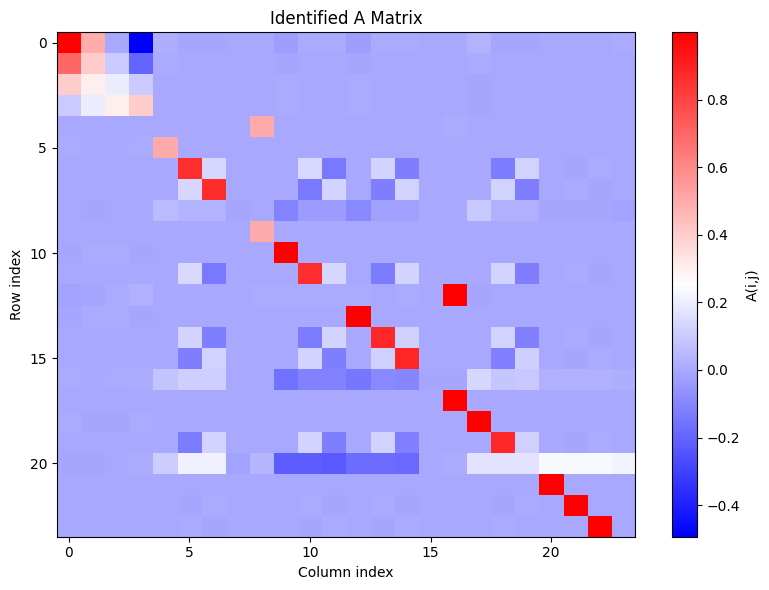

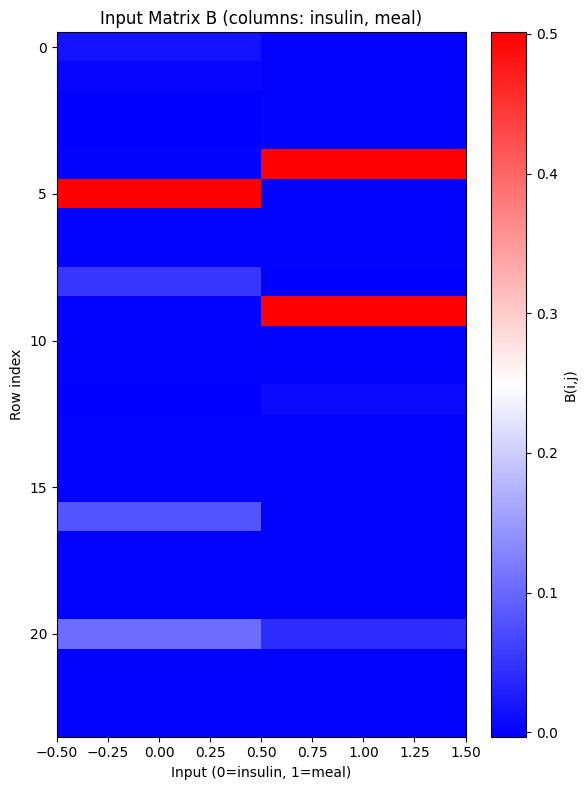

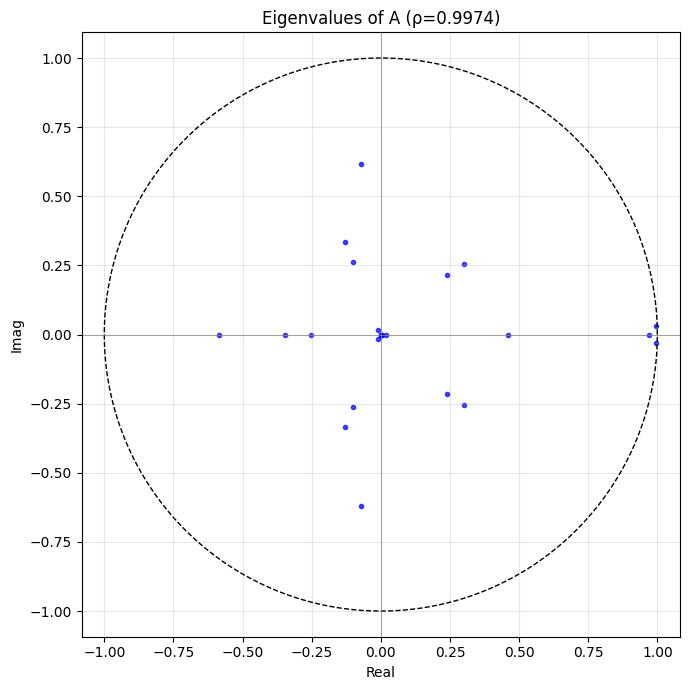


--- Continuous-time poles and time constants ---
(Based on transformation s = log(λ) / dt)
For stable modes (|λ|<1) time constant τ = -1/Re(s) minutes
----------------------------------------------------------------------
 Idx |     λ (real)     λ (imag)        |λ| |        Re(s)        Im(s)    τ (min)
----------------------------------------------------------------------
   1 |       0.9970      -0.0292     0.9974 |      -0.0009      -0.0098    1142.25
   0 |       0.9970       0.0292     0.9974 |      -0.0009       0.0098    1142.25
   2 |       0.9695       0.0000     0.9695 |      -0.0103       0.0000      96.95
   4 |      -0.0730      -0.6183     0.6226 |      -0.1579      -0.5628       6.33
   3 |      -0.0730       0.6183     0.6226 |      -0.1579       0.5628       6.33
   5 |      -0.5870       0.0000     0.5870 |      -0.1776       1.0472       5.63
   6 |       0.4600       0.0000     0.4600 |      -0.2589       0.0000       3.86
   8 |       0.3022      -0.2559     0.396

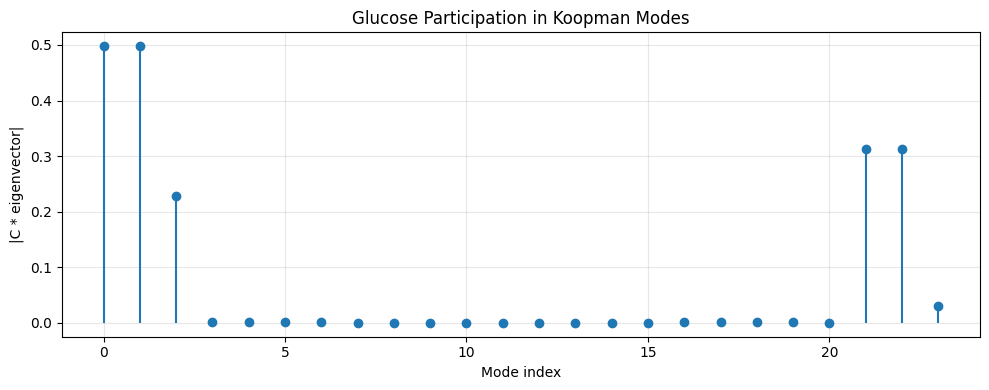


--- Dominant mode (largest |λ| = 0.9974) ---
Eigenvalue: 0.9970 + 0.0292j


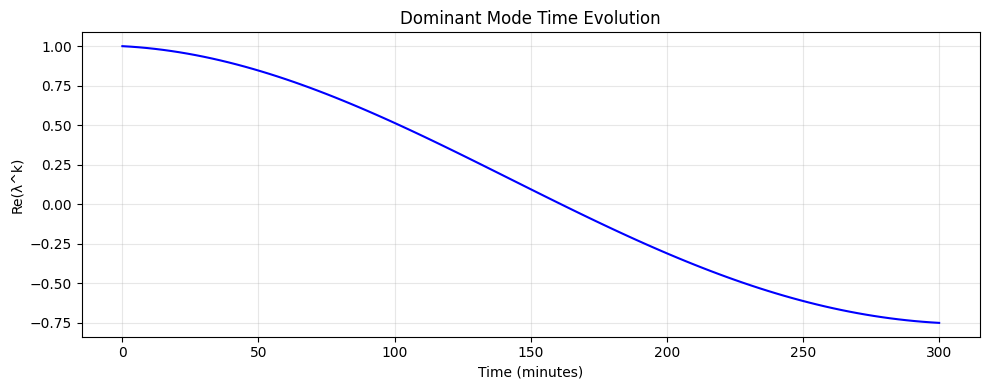

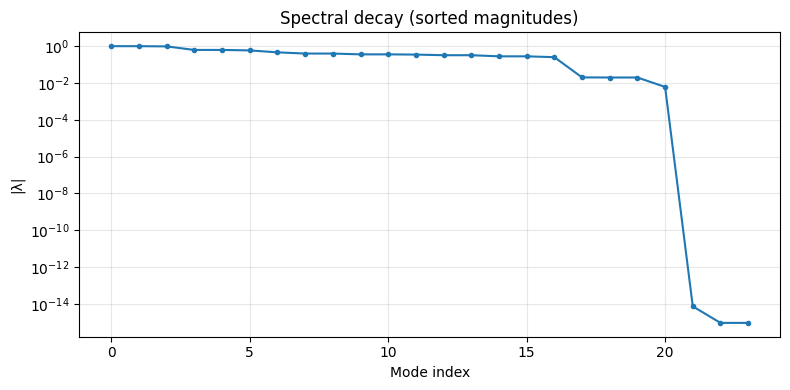


--- Summary ---
Slowest stable time constant: 1142.25 min
Fastest stable time constant: 0.09 min
Modes with |λ| > 0.95 (slow): 3
Modes with |λ| < 0.2  (fast): 7

Inspection complete.


In [13]:
#!/usr/bin/env python3
"""
inspect_identified_model.py

Load a trained Koopman/eDMDc model and visually/numerically inspect its properties.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig, logm, svd, norm, inv

# ----------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------
PATIENT = "adolescent_001"          # change as needed
MODEL_PATH = "../models/edmdc_adolescent_001.npz"
DT = 3.0                              # sampling interval in minutes (should match model)

# ----------------------------------------------------------------------
# Load model
# ----------------------------------------------------------------------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

data = np.load(MODEL_PATH)
A = data['A']
B = data['B']
mean_g = data['mean_g']
std_g = data['std_g']
mean_i = data['mean_i']
std_i = data['std_i']
mean_m = data['mean_m']
std_m = data['std_m']
delays = int(data['delays'])
dt = float(data['dt'])
best_rank = int(data['best_rank'])
rmse_test = float(data['rmse_test'])

# C matrix: selects glucose (first lifted state)
n = A.shape[0]
C = np.zeros((1, n))
C[0, 0] = 1.0

print("=" * 60)
print("IDENTIFIED KOOPMAN MODEL INSPECTION")
print("=" * 60)
print(f"Patient:           {PATIENT}")
print(f"Feature dimension: {n}")
print(f"Best rank:         {best_rank}")
print(f"Test RMSE (2h):    {rmse_test:.2f} mg/dL")
print(f"Sampling interval: {dt} min")
print("-" * 60)

# ----------------------------------------------------------------------
# Basic matrix properties
# ----------------------------------------------------------------------
print("\n--- Matrix Shapes ---")
print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")

# Spectral radius
eigvals = np.linalg.eigvals(A)
spec_rad = np.max(np.abs(eigvals))
print(f"\n--- Spectral radius ---")
print(f"ρ(A) = {spec_rad:.6f}")

# Rank of A
rank_A = np.linalg.matrix_rank(A)
print(f"\n--- Rank of A ---")
print(f"rank(A) = {rank_A} / {n}")

# Controllability matrix and its properties
def controllability_matrix(A, B):
    n = A.shape[0]
    m = B.shape[1]
    Cmat = B.copy()
    Ai = np.eye(n)
    for i in range(1, n):
        Ai = Ai @ A
        Cmat = np.hstack((Cmat, Ai @ B))
    return Cmat

C_ctrb = controllability_matrix(A, B)
rank_ctrb = np.linalg.matrix_rank(C_ctrb)
cond_ctrb = np.linalg.cond(C_ctrb)
s_ctrb = svd(C_ctrb, compute_uv=False)
s_sorted = np.sort(s_ctrb)[::-1]
print(f"\n--- Controllability ---")
print(f"Controllability matrix shape: {C_ctrb.shape}")
print(f"rank = {rank_ctrb} / {n}  (full rank: {rank_ctrb == n})")
print(f"condition number = {cond_ctrb:.2e}")
print(f"σ_min / σ_max = {s_sorted[-1]/s_sorted[0]:.2e}")

# ----------------------------------------------------------------------
# Plot A matrix heatmap
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(A, cmap='bwr', aspect='auto', interpolation='none')
plt.colorbar(label='A(i,j)')
plt.title('Identified A Matrix')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Plot B matrix heatmap (two columns: insulin, meal)
# ----------------------------------------------------------------------
plt.figure(figsize=(6, 8))
plt.imshow(B, cmap='bwr', aspect='auto', interpolation='none')
plt.colorbar(label='B(i,j)')
plt.title('Input Matrix B (columns: insulin, meal)')
plt.xlabel('Input (0=insulin, 1=meal)')
plt.ylabel('Row index')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Eigenvalue plot
# ----------------------------------------------------------------------
plt.figure(figsize=(7, 7))
plt.scatter(np.real(eigvals), np.imag(eigvals), c='b', marker='.', alpha=0.7)
# Unit circle
theta = np.linspace(0, 2*np.pi, 200)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.axis('equal')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title(f'Eigenvalues of A (ρ={spec_rad:.4f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Continuous-time poles and time constants
# ----------------------------------------------------------------------
print("\n--- Continuous-time poles and time constants ---")
print("(Based on transformation s = log(λ) / dt)")
print("For stable modes (|λ|<1) time constant τ = -1/Re(s) minutes")
print("-" * 70)
print(f"{'Idx':>4} | {'λ (real)':>12} {'λ (imag)':>12} {'|λ|':>10} | {'Re(s)':>12} {'Im(s)':>12} {'τ (min)':>10}")
print("-" * 70)

# Sort eigenvalues by descending magnitude
order = np.argsort(np.abs(eigvals))[::-1]
dominant_modes = []
for idx_in_list, i in enumerate(order[:8]):   # top 8 by magnitude
    lam = eigvals[i]
    mag = np.abs(lam)
    s = np.log(lam) / dt   # principal branch; careful with branch cuts
    tau = -1.0 / np.real(s) if (np.real(s) < 0 and mag < 1) else np.inf
    dominant_modes.append((i, lam, mag, s, tau))
    print(f"{i:4d} | {lam.real:12.4f} {lam.imag:12.4f} {mag:10.4f} | {s.real:12.4f} {s.imag:12.4f} {tau:10.2f}")

# ----------------------------------------------------------------------
# Glucose participation in Koopman modes
# ----------------------------------------------------------------------
V = np.linalg.eig(A)[1]   # eigenvectors, columns are right eigenvectors
glucose_part = np.abs(V[0, :])  # first row corresponds to glucose

# Sort by participation
order_part = np.argsort(glucose_part)[::-1]
print("\n--- Top 5 modes by glucose participation ---")
print(f"{'Mode idx':>8} | {'Glucose part.':>14} | {'|λ|':>8}")
print("-" * 40)
for i in order_part[:5]:
    print(f"{i:8d} | {glucose_part[i]:14.4f} | {np.abs(eigvals[i]):8.4f}")

# Stem plot of glucose participation
plt.figure(figsize=(10, 4))
plt.stem(range(n), glucose_part, basefmt=' ')
plt.xlabel('Mode index')
plt.ylabel('|C * eigenvector|')
plt.title('Glucose Participation in Koopman Modes')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Dominant mode time evolution
# ----------------------------------------------------------------------
# Find eigenvalue with largest magnitude (dominant mode)
idx_dom = np.argmax(np.abs(eigvals))
lam_dom = eigvals[idx_dom]
print(f"\n--- Dominant mode (largest |λ| = {np.abs(lam_dom):.4f}) ---")
print(f"Eigenvalue: {lam_dom.real:.4f} + {lam_dom.imag:.4f}j")

# Simulate its evolution in lifted space: mode evolves as λ^k
# We'll plot the real part of λ^k for k from 0 to steps corresponding to 300 minutes
steps = int(300 / dt) + 1
k = np.arange(steps)
time = k * dt
mode_evolution = np.real(lam_dom ** k)

plt.figure(figsize=(10, 4))
plt.plot(time, mode_evolution, 'b-')
plt.xlabel('Time (minutes)')
plt.ylabel('Re(λ^k)')
plt.title('Dominant Mode Time Evolution')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Mode energy distribution (sorted |λ|)
# ----------------------------------------------------------------------
sorted_mag = np.sort(np.abs(eigvals))[::-1]
plt.figure(figsize=(8, 4))
plt.semilogy(sorted_mag, 'o-', markersize=3)
plt.xlabel('Mode index')
plt.ylabel('|λ|')
plt.title('Spectral decay (sorted magnitudes)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Summary statistics
# ----------------------------------------------------------------------
# Time constants for stable modes (|λ| < 1)
stable = np.abs(eigvals) < 1.0
if np.any(stable):
    s_stable = np.log(eigvals[stable]) / dt
    tau_stable = -1.0 / np.real(s_stable)
    tau_stable = tau_stable[np.isfinite(tau_stable)]   # remove inf if any
    slowest = np.max(tau_stable) if len(tau_stable) > 0 else np.nan
    fastest = np.min(tau_stable) if len(tau_stable) > 0 else np.nan
else:
    slowest = fastest = np.nan

n_slow = np.sum(np.abs(eigvals) > 0.95)
n_fast = np.sum(np.abs(eigvals) < 0.2)

print("\n--- Summary ---")
print(f"Slowest stable time constant: {slowest:.2f} min" if not np.isnan(slowest) else "Slowest stable time constant: N/A")
print(f"Fastest stable time constant: {fastest:.2f} min" if not np.isnan(fastest) else "Fastest stable time constant: N/A")
print(f"Modes with |λ| > 0.95 (slow): {n_slow}")
print(f"Modes with |λ| < 0.2  (fast): {n_fast}")

print("\n" + "=" * 60)
print("Inspection complete.")

In [12]:
import os

for root, dirs, files in os.walk(os.getcwd()):
    for file in files:
        if file.endswith(".npz"):
            print(os.path.join(root, file))

C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\notebooks\edmdc_model.npz


In [36]:
with open("edmdc_pipeline.py", "r") as f:
    content = f.read()

print("MODAL CONTROLLABILITY ANALYSIS" in content)

True


In [37]:
for i, line in enumerate(content.split("\n")):
    if "MODAL CONTROLLABILITY" in line:
        print(i, line)

464     print("MODAL CONTROLLABILITY ANALYSIS")


In [16]:
import os
import time

results_dir = r"C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\results"

for f in os.listdir(results_dir):
    path = os.path.join(results_dir, f)
    print(f, "->", time.ctime(os.path.getmtime(path)))


adolescent_001_eigenvalues.png -> Fri Feb 20 16:26:46 2026
adolescent_001_error_growth.png -> Fri Feb 20 16:26:47 2026
adolescent_001_long_horizon_errors.png -> Fri Feb 20 16:26:45 2026
adolescent_001_prediction.png -> Fri Feb 20 16:26:46 2026
adolescent_001_residuals.png -> Fri Feb 20 16:26:47 2026
adolescent_001_singular_values.png -> Fri Feb 20 16:26:46 2026


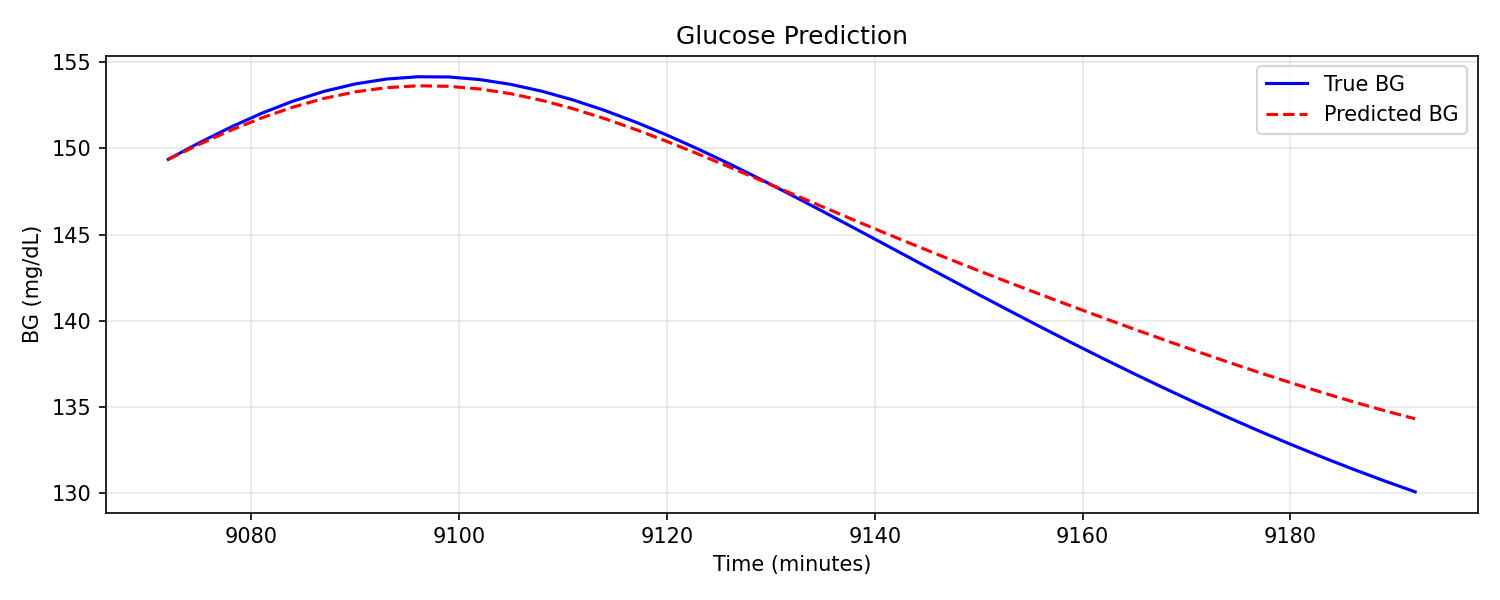

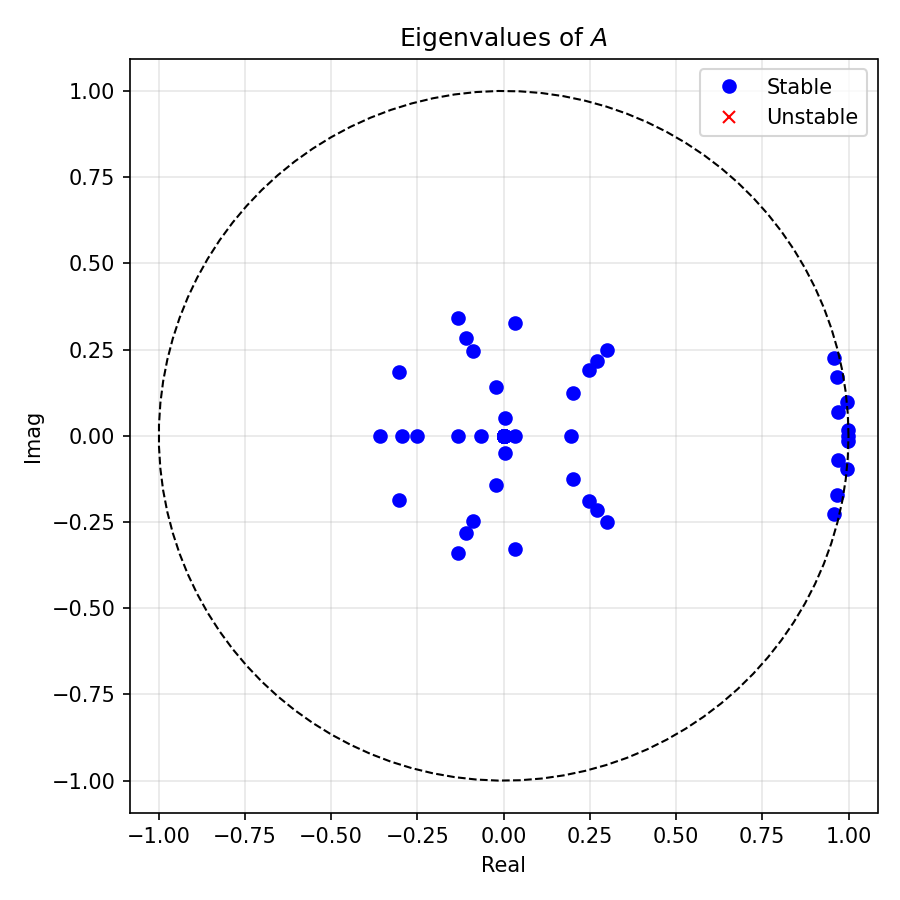

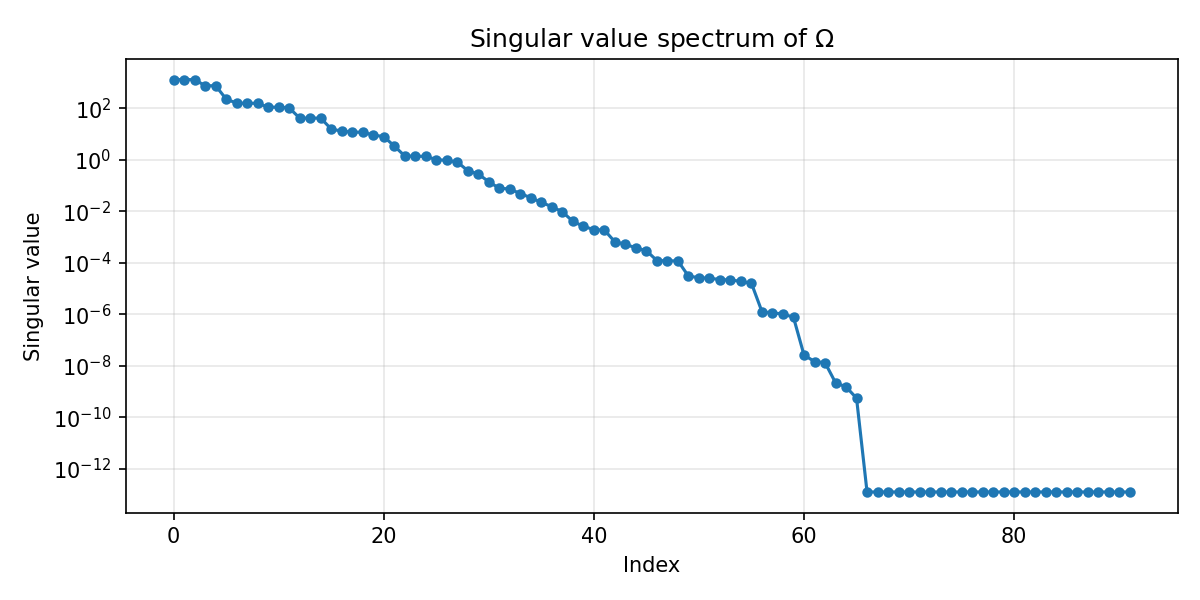

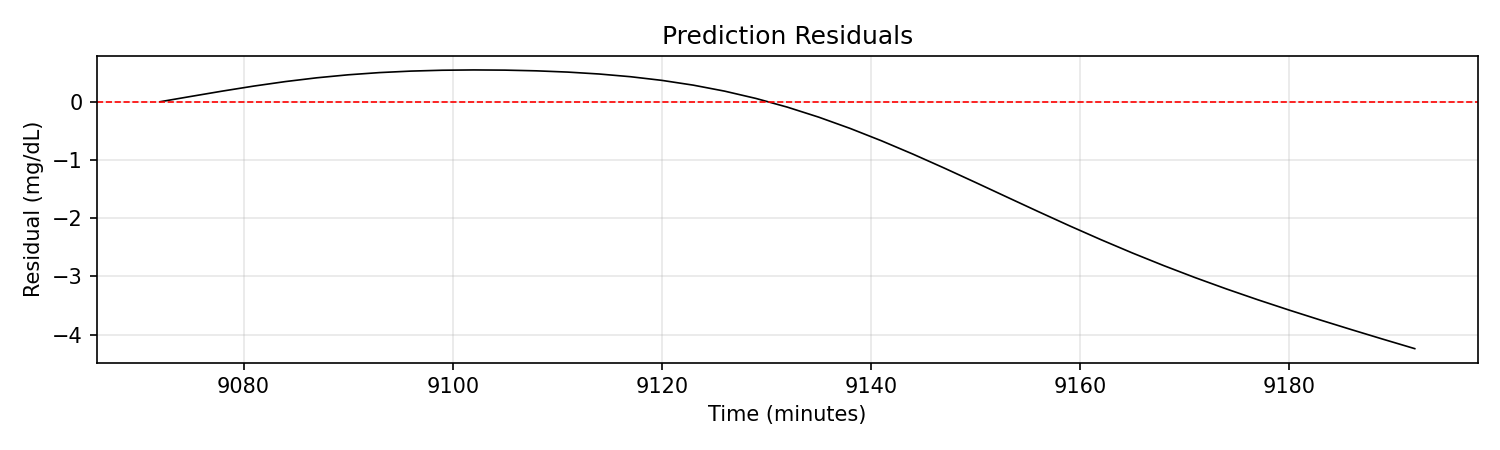

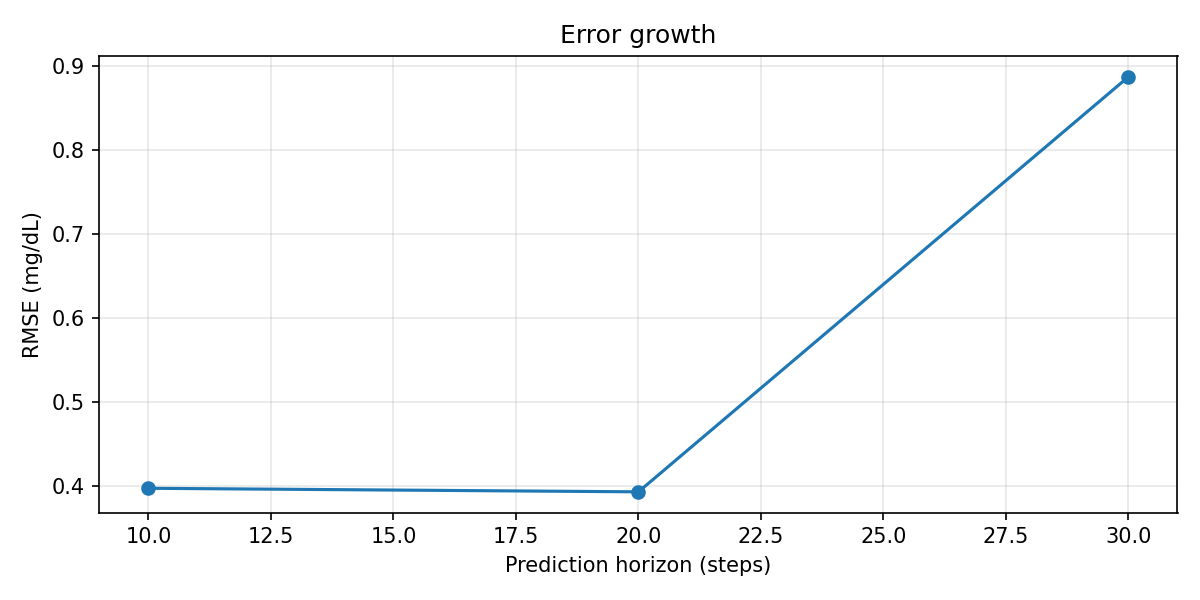

In [17]:
from IPython.display import Image, display
import os

results_dir = r"C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\results"

files = [
    "adolescent_001_prediction.png",
    "adolescent_001_eigenvalues.png",
    "adolescent_001_singular_values.png",
    "adolescent_001_residuals.png",
    "adolescent_001_error_growth.png"
]

for f in files:
    path = os.path.join(results_dir, f)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print("Not found:", path)
